# JMH Benchmark Parser & Plotting Toolkit

This notebook provides:
1. A parser to extract datasets from JMH-style table output into typed arrays grouped by benchmark name.
2. Plotting helpers to compare **2, 3, 4, or 5** datasets on one chart.
3. A regression plotter that overlays a polynomial fit of configurable degree.

**Conventions**
- Parsed structure per benchmark: `List[Tuple[int, Tuple[float, float]]]` → `(size, (avg, error))`.
- `size` is taken from the filename part like `... 2_456chars.json ...` → `456`.
- Plot functions accept optional `output_folder` and `fmt` (`"svg"` or `"eps"`). If provided, figures are saved there.


In [1]:

# Imports (matplotlib only; seaborn intentionally not used)
from __future__ import annotations
import re
from typing import Dict, List, Tuple, Sequence, Iterable, Optional
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

def _ensure_save(fig, filename: Optional[str|Path], fmt: str = "svg", output_folder: Optional[str|Path] = None):
    """Save `fig` if `output_folder` is provided. Returns output path or None."""
    if output_folder is None:
        return None
    fmt = (fmt or "svg").lower()
    if fmt not in {"svg", "eps", "pdf", "png"}:
        raise ValueError(f"Unsupported format: {fmt!r}. Use 'svg', 'eps', 'pdf', or 'png'.")
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    filename = Path(filename) if filename is not None else Path("figure")
    outpath = output_folder / (filename.stem + f".{fmt}")
    fig.savefig(outpath, format=fmt, bbox_inches="tight", dpi=300)
    return outpath


In [2]:

def parse_jmh_table(raw_text: str) -> Dict[str, List[Tuple[int, Tuple[float, float]]]]:
    """Parse JMH-like '[info] Benchmark ...' table lines into datasets.

    Returns a dict mapping benchmark name → list of (size, (avg, error)).
    The list is sorted by size. Lines that don't match the expected table pattern are ignored.

    Expected columns pattern (loose, handles variable spacing):
      [info] <BenchmarkName> <file> <mode> <cnt> <score> ± <error> <units>

    Size extraction rule:
      Take the integer *immediately before* the 'chars' token in the filename.
      E.g., '102_23677chars.json' → 23677 ; '2_456chars.json' → 456.
    """
    datasets: Dict[str, List[Tuple[int, Tuple[float, float]]]] = {}

    # Regex for the table line
    line_re = re.compile(
        r"^\[info\]\s+"                               # prefix
        r"(?P<bench>\S+)\s+"                           # benchmark name
        r"(?P<file>\S+)\s+"                            # filename token
        r"(?P<mode>\S+)\s+"                            # mode (e.g., avgt)
        r"(?P<cnt>\d+)\s+"                             # count
        r"(?P<score>\d+(?:\.\d+)?)\s+"               # score (avg)
        r"±\s+"
        r"(?P<error>\d+(?:\.\d+)?)\s+"               # error
        r"(?P<units>\S+)\s*$"                          # units
    )

    # Extract the size found right before 'chars' inside the file token
    size_re = re.compile(r"_(?P<size>\d+)chars\b", re.IGNORECASE)

    for line in raw_text.splitlines():
        m = line_re.match(line)
        if not m:
            continue

        bench = m.group("bench")
        filetok = m.group("file")
        score = float(m.group("score"))
        error = float(m.group("error"))

        sm = size_re.search(filetok)
        if not sm:
            # If pattern fails, try to fallback to the last integer run in the token
            # (keeps the parser resilient for edge cases).
            m2 = re.search(r"(\d+)(?=\D*$)", filetok)
            if not m2:
                continue
            size = int(m2.group(1))
        else:
            size = int(sm.group("size"))

        datasets.setdefault(bench, []).append((size, (score, error)))

    # Sort each dataset by size
    for k in list(datasets.keys()):
        datasets[k].sort(key=lambda t: t[0])

    return datasets


In [3]:

from matplotlib import colors

def _clean_filename(s: str) -> str:
    filename_clean = s.replace("\n", "_").replace(" ", "_").replace("/", "_").replace(":", "_").replace(",", "_").replace(".", "_").replace("(", "_").replace(")", "_").replace("*", "-").replace("&", "and")
    changed = True
    while changed:
        new_clean = filename_clean.replace("__", "_")
        changed = (new_clean != filename_clean)
        filename_clean = new_clean
    return filename_clean

def _prep_xy(series: List[Tuple[int, Tuple[float, float]]]):
    xs = [s for s, _ in series]
    ys = [v[0] for _, v in series]
    yerr = [v[1] for _, v in series]
    return np.array(xs), np.array(ys), np.array(yerr)

# A list of easily distinguishable colors for colorblind-safe plots
_COLOR_CYCLE = [
    "#007bff",  # blue
    "#000000",  # black
    "#ff7f00",  # orange
    "#ff47a6",  # pink
    "#bdbd1d",  # yellow
    "#006354",  # teal
]

def _plot_many(datasets: Sequence[Tuple[str, List[Tuple[int, Tuple[float, float]]]]], 
               pretty_data_labels: Optional[Dict[str, str]] = None,
               title: Optional[str] = None,
               show_title: bool = False,
               output_folder: Optional[str|Path] = None,
               fmt: str = "svg",
               time_unit: str = "µs",
               convert_data_from_micro_sec: bool = False,
               filename: Optional[str|Path] = None,
               fontsize: int = -1,
               shape_cycle: Optional[List[str]] = None,
               color_cycle: List[str] = _COLOR_CYCLE,
               error_bars: bool = True):
    n = len(datasets)
    if n < 2 or n > 6:
        raise ValueError("_plot_many expects between 2 and 6 datasets.")
    
    factor = 1.0
    if convert_data_from_micro_sec:
        # We convert from µs to the desired time unit
        if time_unit == "ms":
            factor = 1e-3
        elif time_unit == "s":
            factor = 1e-6
        elif time_unit == "ns":
            factor = 1e3    
        elif time_unit == "µs":
            factor = 1.0
        else:
            raise ValueError(f"Unsupported time unit for conversion: {time_unit!r}. Use 'ns', 'µs', 'ms', or 's'.")


    fig, ax = plt.subplots(figsize=(7, 5))
    index = 0
    shape_cycle = shape_cycle or ['o']
    for label, series in datasets:
        xs, ys, yerr = _prep_xy(series)
        ys = ys * factor
        yerr = yerr * factor
        if pretty_data_labels and label in pretty_data_labels:
            label = pretty_data_labels[label]
        if not error_bars:
            yerr = None
        ax.errorbar(xs, ys, yerr=yerr, marker=shape_cycle[index % len(shape_cycle)], linestyle='', label=label, 
                    color=color_cycle[index % len(color_cycle)],
                    capsize=3)
        index += 1
    ax.set_xlabel("Input size (chars)")
    ax.set_ylabel(f"Time ({time_unit})")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    if title and show_title:
        ax.set_title(title)
    else:
        print("Title: ", title)
    if fontsize > 0:
        ax.legend(fontsize=fontsize)
    else:
        ax.legend()

    filename_clean = _clean_filename((filename or (title or f"compare_{n}_datasets")))
    
    saved = _ensure_save(fig, filename_clean, fmt, output_folder)
    plt.show()
    return saved

def plot2(d1: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
          d2: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
          pretty_data_labels: Optional[Dict[str, str]] = None,
          title: Optional[str] = None,
          show_title: bool = False,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          filename: Optional[str|Path] = None,
          fontsize: int = -1,
          shape_cycle: Optional[List[str]] = None,
          error_bars: bool = True,
          color_cycle: List[str] = _COLOR_CYCLE):
    """Plot 2 datasets on the same axes."""
    return _plot_many([d1, d2], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, filename=filename, fontsize=fontsize, shape_cycle=shape_cycle, error_bars=error_bars, color_cycle=color_cycle)

def plot3(d1, d2, d3, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          filename: Optional[str|Path] = None,
          fontsize: int = -1,
          shape_cycle: Optional[List[str]] = None,
          error_bars: bool = True,
          color_cycle: List[str] = _COLOR_CYCLE):
    """Plot 3 datasets on the same axes."""
    return _plot_many([d1, d2, d3], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, filename=filename, fontsize=fontsize, shape_cycle=shape_cycle, error_bars=error_bars, color_cycle=color_cycle)

def plot4(d1, d2, d3, d4, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          filename: Optional[str|Path] = None,
          fontsize: int = -1,
          shape_cycle: Optional[List[str]] = None,
          error_bars: bool = True,
          color_cycle: List[str] = _COLOR_CYCLE):
    """Plot 4 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, filename=filename, fontsize=fontsize, shape_cycle=shape_cycle, error_bars=error_bars, color_cycle=color_cycle)

def plot5(d1, d2, d3, d4, d5, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          filename: Optional[str|Path] = None,
          fontsize: int = -1,
          shape_cycle: Optional[List[str]] = None,
          error_bars: bool = True,
          color_cycle: List[str] = _COLOR_CYCLE):
    """Plot 5 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4, d5], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, filename=filename, fontsize=fontsize, shape_cycle=shape_cycle, error_bars=error_bars, color_cycle=color_cycle)

def plot6(d1, d2, d3, d4, d5, d6, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          filename: Optional[str|Path] = None, 
          fontsize: int = -1,
          shape_cycle: Optional[List[str]] = None,
          error_bars: bool = True,
          color_cycle: List[str] = _COLOR_CYCLE):
    """Plot 6 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4, d5, d6], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, filename=filename, fontsize=fontsize, shape_cycle=shape_cycle, error_bars=error_bars, color_cycle=color_cycle)

In [4]:

def _print_poly(poly: np.poly1d):
    equation = ""
    degree = len(poly.coeffs) - 1
    for i, coeff in enumerate(poly.coeffs):
        power = degree - i
        coeff_abs = abs(coeff)
        if coeff < 0:
            equation += " - "
        else:
            if i > 0:
                equation += " + "
        if power == 0:
            equation += f"{coeff_abs:.4g}"
        elif power == 1:
            equation += f"{coeff_abs:.4g}*x"
        else:
            equation += f"{coeff_abs:.4g}*x^{power}"
    print(f"Polynomial function f(x) = {equation}")

def plot_with_regression(dataset: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
                         degree: int | str = 1,
                         title: Optional[str] = None,
                         show_title: bool = False,
                         color: Optional[str] = None,
                         pretty_data_labels: Optional[Dict[str, str]] = None,
                         output_folder: Optional[str|Path] = None,
                         fmt: str = "svg",
                         time_unit: str = "µs",
                         custom_additional_y_label: str = "",
                         convert_data_from_micro_sec: bool = False,
                         filename: Optional[str|Path] = None,
                         fontsize: int = -1):
    """Plot a dataset with error bars and overlay a polynomial regression of given degree.

    Parameters
    ----------
    dataset : (name, series) where series is List[(size, (avg, error))].
    degree : polynomial degree (>= 0). degree "nlogn" is used for n log n regression.
    title : optional str for the plot title.
    output_folder : optional path to save the plot.
    fmt : 'svg' or 'eps' (default: 'svg').
    filename : optional filename stem for saving.
    """
    if (isinstance(degree, int) and degree < 0) or (isinstance(degree, str) and degree != "nlogn"):
        raise ValueError("degree must be >= 0")
    
    factor = 1.0
    if convert_data_from_micro_sec:
        # We convert from µs to the desired time unit
        if time_unit == "ms":
            factor = 1e-3
        elif time_unit == "s":
            factor = 1e-6
        elif time_unit == "ns":
            factor = 1e3    
        elif time_unit == "µs":
            factor = 1.0
        else:
            raise ValueError(f"Unsupported time unit for conversion: {time_unit!r}. Use 'ns', 'µs', 'ms', or 's'.")

    
    label, series = dataset
    xs, ys, yerr = _prep_xy(series)
    
    ys = ys * factor
    yerr = yerr * factor

        # Fit polynomial
    if degree == "nlogn":
        # Model: y = a*(x log2 x) + b
        if np.any(xs <= 0):
            raise ValueError("n log n regression requires all x values to be > 0")

        xs_transformed = xs * np.log2(xs)
        coeffs = np.polyfit(xs_transformed, ys, deg=1)
        poly = np.poly1d(coeffs)

        # Smooth line over the observed range
        xfit = np.linspace(xs.min(), xs.max(), 500)
        xfit_transformed = xfit * np.log2(xfit)
        yfit = poly(xfit_transformed)

        reg_label = "a*(n log2 n) + b"
    else:
        coeffs = np.polyfit(xs, ys, deg=degree)
        poly = np.poly1d(coeffs)

        # Smooth line over the observed range
        xfit = np.linspace(xs.min(), xs.max(), 500)
        yfit = poly(xfit)

        if isinstance(degree, int) and degree == 1:
            reg_label = f"Linear regression"
        else:
            reg_label = f"Polynomial of degree {degree}"

    if color is None:
        color = _COLOR_CYCLE[0]
    fig, ax = plt.subplots(figsize=(7, 5))
    if pretty_data_labels and label in pretty_data_labels:
            label = pretty_data_labels[label]
    ax.errorbar(xs, ys, yerr=yerr, marker='o', color=color, linestyle='--', label=f"{label}")
    ax.plot(xfit, yfit, label=reg_label, color='gray')
    ax.set_xlabel("Input size (chars)" + custom_additional_y_label)
    ax.set_ylabel(f"Time ({time_unit})")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    if fontsize > 0:
        ax.legend(fontsize=fontsize)
    else:
        ax.legend()
    if title and show_title:
        ax.set_title(title)
    else:
        print("Title: ", title)

    filename_clean = _clean_filename((filename or (title or f"regression_deg{degree}_{label}")))

    saved = _ensure_save(fig, filename_clean, fmt, output_folder)
    plt.show()

    if degree == 1.5:
        a, b = poly.coeffs  # since deg=1
        print(f"n log n function f(n) = {a:.4g}*(n*log2(n)) + {b:.4g}")
    else:
        _print_poly(poly)
    return saved


def plot_distribution(data: Iterable[float],
                      title: Optional[str] = None,
                      show_title: bool = False,
                      x_label: Optional[str] = None,
                      y_label: Optional[str] = None,
                      output_folder: Optional[str|Path] = None,
                      fmt: str = "svg",
                      bins: int = 30,
                      log_scale: bool = False,
                      filename: Optional[str|Path] = None,
                      fontsize: int = -1):
    """Plot a histogram distribution of the provided data."""
    fig, ax = plt.subplots(figsize=(7, 5))
    color = _COLOR_CYCLE[0]
    if log_scale:
        ax.set_yscale('log')
    ax.hist(data, bins=bins, color=color, alpha=0.7, edgecolor='black')
    if x_label:
        ax.set_xlabel(x_label)
    else:
        ax.set_xlabel("Value")
    if y_label:
        ax.set_ylabel(y_label)
    else:
        ax.set_ylabel("Frequency")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    if title and show_title:
        ax.set_title(title)
    else:
        print("Title: ", title)
    if fontsize > 0:
        ax.legend(fontsize=fontsize)

    filename_clean = _clean_filename((filename or (title or "distribution_histogram")))

    saved = _ensure_save(fig, filename_clean, fmt, output_folder)
    plt.show()
    return saved



### Usage
```python
raw = """<paste your JMH output here>"""
data = parse_jmh_table(raw)

# Example: build tuples for plotting
bench1 = "JsonLexerBenchmark.lex_ZipperMem"
bench2 = "JsonLexerBenchmark.separability_pred"
d1 = (bench1, data[bench1])
d2 = (bench2, data[bench2])

# Compare two datasets
plot2(d1, d2, title="Lex vs Separability", output_folder="plots", fmt="svg")

# Regression for one dataset
plot_with_regression(d2, degree=1, title="Separability: Linear Fit", output_folder="plots", fmt="svg")
```


In [5]:
# delete the 'plots' output folder
if os.path.exists("plots"):
    import shutil
    shutil.rmtree("plots")

# JSON Lexer Benchmark Results

Title:  JSON: Lex vs Separability vs LexV1 (Latest)


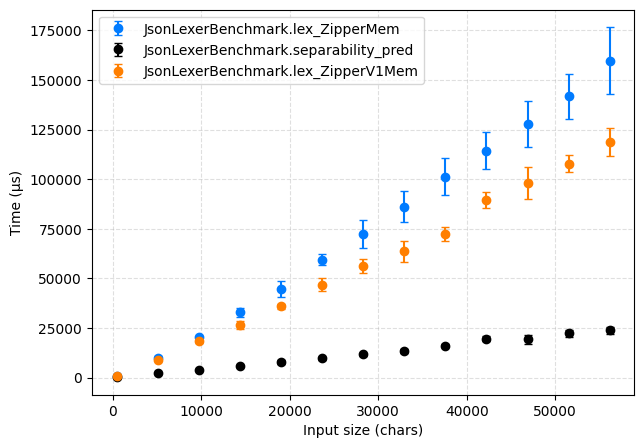

Title:  JSON: Lex vs Separability (Latest)


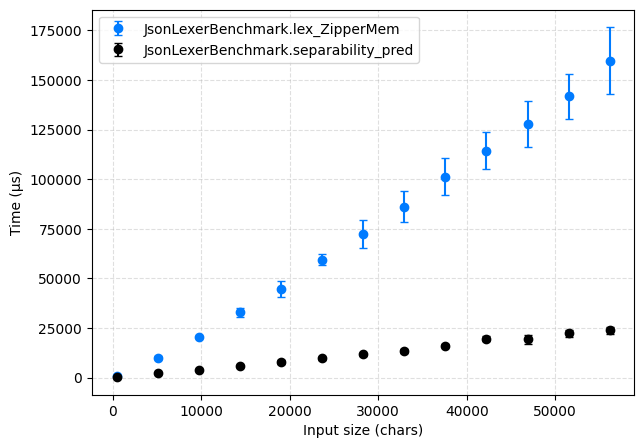

In [6]:
latest_folder = Path("./latest")
json_lexer_file = None
for entry in os.listdir(latest_folder):
    if 'json_lexer' in entry.lower():
        json_lexer_file = latest_folder / entry
        break

bench_zipperMem = "JsonLexerBenchmark.lex_ZipperMem"
bench_separability = "JsonLexerBenchmark.separability_pred"
bench_zipperV1Mem = "JsonLexerBenchmark.lex_ZipperV1Mem"
bench_zipperV1NonMem = "JsonLexerBenchmark.lex_ZipperV1NonMem"
bench_zipperV2MemOnlyDeriv = "JsonLexerBenchmark.lex_ZipperV2MemOnlyDeriv"

assert json_lexer_file is not None, "Could not find JSON lexer benchmark file in 'latest' folder."
with open(json_lexer_file, "r") as f:
    raw2 = f.read()
data2 = parse_jmh_table(raw2)
if bench_zipperMem in data2 and bench_separability in data2 and bench_zipperV1Mem in data2 and bench_zipperV1NonMem in data2 and bench_zipperV2MemOnlyDeriv in data2:
    d_zipperMem = (bench_zipperMem, data2[bench_zipperMem])
    d_separability = (bench_separability, data2[bench_separability])
    d_zipperV1Mem = (bench_zipperV1Mem, data2[bench_zipperV1Mem])
    d_zipperV1NonMem = (bench_zipperV1NonMem, data2[bench_zipperV1NonMem])
    d_zipperV2MemOnlyDeriv = (bench_zipperV2MemOnlyDeriv, data2[bench_zipperV2MemOnlyDeriv])
    plot3(
        d_zipperMem,
        d_separability,
        d_zipperV1Mem,
        title="JSON: Lex vs Separability vs LexV1 (Latest)",
        # output_folder="plots",
        output_folder=None,
        fmt="eps",
    )
    plot2(
        d_zipperMem,
        d_separability,
        title="JSON: Lex vs Separability (Latest)",
        # output_folder="plots",
        output_folder=None,
        fmt="eps",
    )
    # plot4(d_zipperMem, d_zipperV1Mem, d_zipperV1NonMem, d_zipperV2NonMem, title="JSON: Lex Variants Comparison (Latest)", output_folder="plots", fmt="eps")
    # plot4(d_zipperMem, d_zipperV1Mem, d_zipperV2MemOnlyDeriv, d_zipperV2NonMem, title="JSON: Lex Variants Comparison (Latest)", output_folder="plots", fmt="eps")
else:
    print(f"Benchmarks {bench_zipperMem} or {bench_separability} not found in the latest data.")

# JSON Manipulation Benchmark Results

Title:  JSON Sorting: Recombining With vs Without Wrapper


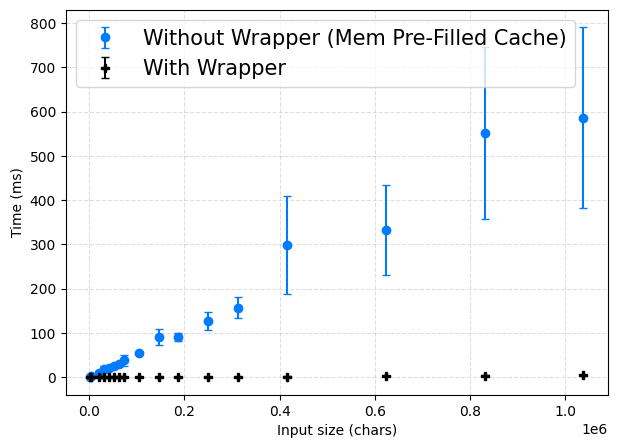

Title:  JSON Sorting: Lexing with Polynomial Regression (deg 1)


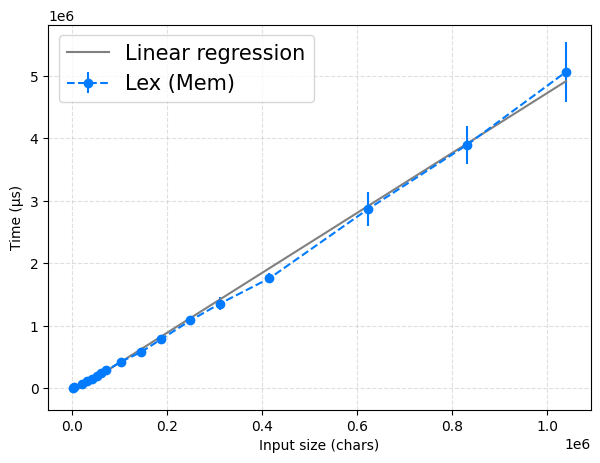

Polynomial function f(x) = 4.806*x - 7.545e+04
Title:  JSON Sorting: Lexing V1 with Polynomial Regression (deg 1)


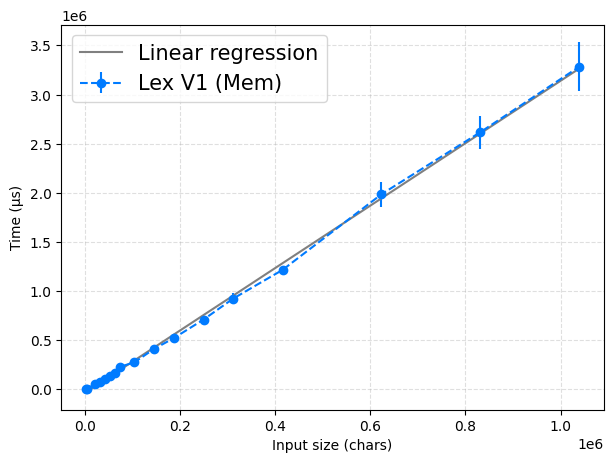

Polynomial function f(x) = 3.175*x - 3.439e+04
Title:  JSON Sorting: Slicing and Sorting with Polynomial Regression (deg 1)


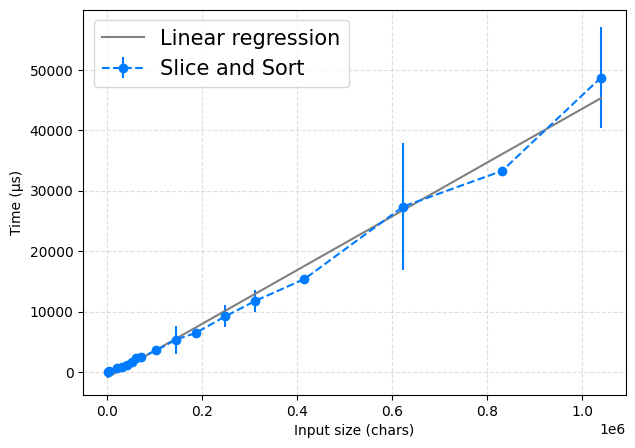

Polynomial function f(x) = 0.04453*x - 962.6
Title:  JSON Sorting: Lex and R-Path sep vs Lex Only (Mem) V1


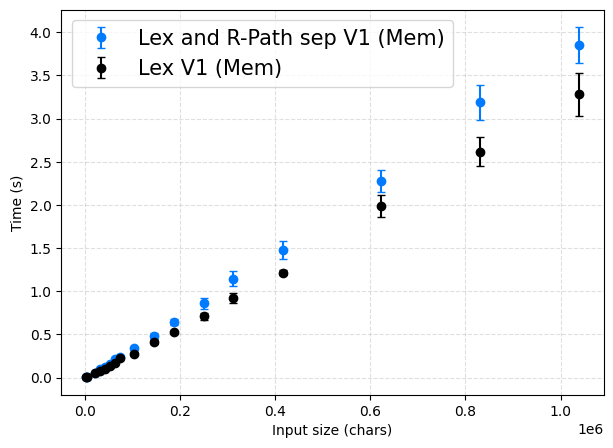

Title:  JSON Sorting: Lex and R-Path sep vs Lex Only (Mem) V3


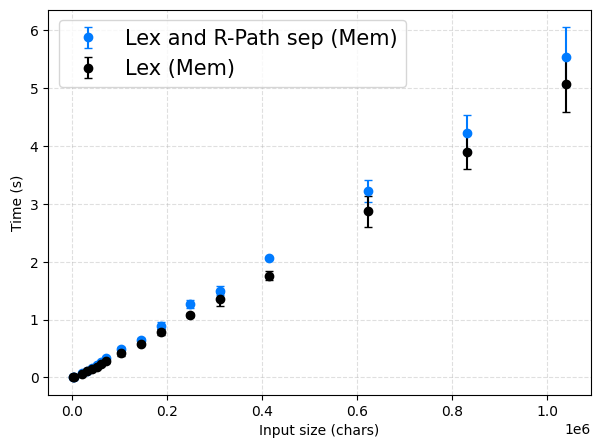

Title:  JSON Sorting: Lex Only (Mem vs Non-Mem) V1


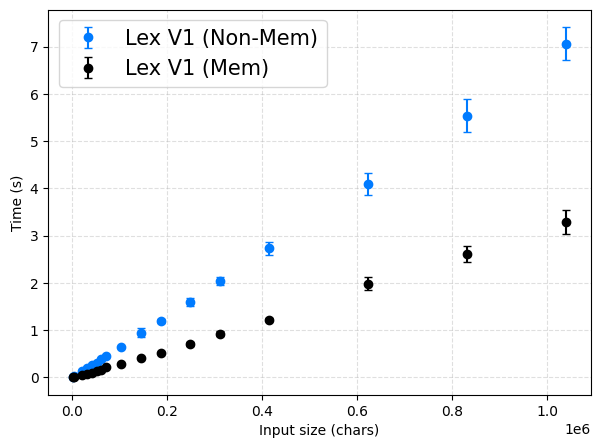

Title:  JSON Sorting: Lex V1 vs Lex V2 (Mem)


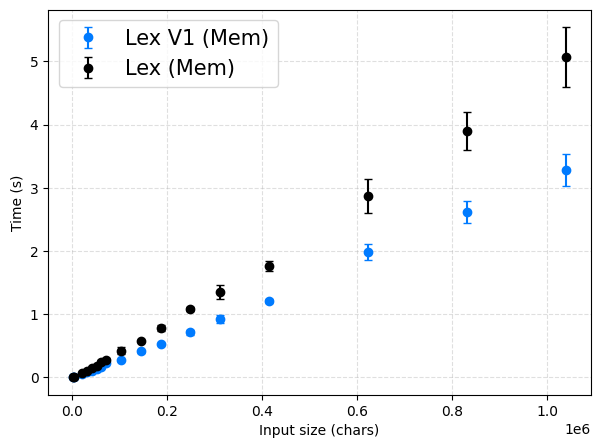

Title:  JSON Sorting: sep (Non-Mem) vs sep (Mem Pre-Filled Cache)


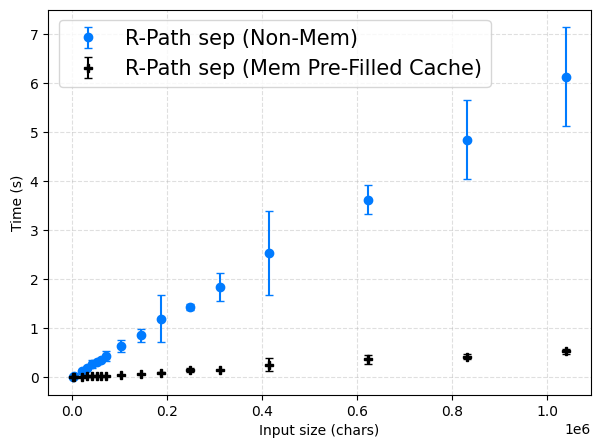

PosixPath('plots/JSON_Sorting_sep_Non-Mem_vs_sep_Mem_Pre-Filled_Cache_.pdf')

In [7]:
latest_folder = Path("./latest")
json_manipulation_file = None
for entry in os.listdir(latest_folder):
    if 'json_manipulation' in entry.lower():
        json_manipulation_file = latest_folder / entry
        break

# If found, parse and plot
assert json_manipulation_file is not None, "No json_manipulation file found in latest folder."
with open(json_manipulation_file, "r") as f:
  raw3 = f.read()
  data3 = parse_jmh_table(raw3)

benchRecombineWithoutWrapper = "JsonManipulationBenchmark.checkPredicateAndRecombineWithoutWrapper"
benchLex = "JsonManipulationBenchmark.lex"
benchLexV1 = "JsonManipulationBenchmark.lexV1"
benchLexV1NonMem = "JsonManipulationBenchmark.lexV1NonMem"
benchLexAndCheckPrintableV1 = "JsonManipulationBenchmark.lexAndCheckPrintableV1"
benchLexAndCheckPrintableV3 = "JsonManipulationBenchmark.lexAndCheckPrintableV3"
benchRecombineSlices = "JsonManipulationBenchmark.recombineSlices"
benchSliceAndSort = "JsonManipulationBenchmark.sliceAndSort"
benchCheckPrintableNonMem = "JsonManipulationBenchmark.checkPrintableNonMem"
benchCheckPrintable = "JsonManipulationBenchmark.checkPrintableMemPreFilledCache"

pretty_labels = {
      benchRecombineWithoutWrapper: "Without Wrapper (Mem Pre-Filled Cache)",
      benchLex: "Lex (Mem)",
      benchLexV1: "Lex V1 (Mem)",
      benchLexV1NonMem: "Lex V1 (Non-Mem)",
      # benchLexV2NonMem: "Lex V2 (Non-Mem)",
      benchLexAndCheckPrintableV1: "Lex and R-Path sep V1 (Mem)",
      benchLexAndCheckPrintableV3: "Lex and R-Path sep (Mem)",
      benchRecombineSlices: "With Wrapper",
      benchSliceAndSort: "Slice and Sort",
      benchCheckPrintableNonMem: "R-Path sep (Non-Mem)",
      benchCheckPrintable: "R-Path sep (Mem Pre-Filled Cache)"
}

plot2((benchRecombineWithoutWrapper, data3[benchRecombineWithoutWrapper]),
      (benchRecombineSlices, data3[benchRecombineSlices]),
      title="JSON Sorting: Recombining With vs Without Wrapper",
      show_title=False,
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      time_unit="ms",
      convert_data_from_micro_sec=True,
      shape_cycle=['o', 'P'],
      fmt="pdf",
      fontsize=15)

plot_with_regression((benchLex, data3[benchLex]),
                     degree=1,
                     title="JSON Sorting: Lexing with Polynomial Regression (deg 1)",
                     show_title=False,
                  #    output_folder="plots",
                     output_folder=None,
                     pretty_data_labels=pretty_labels,
                     fmt="pdf",
                     fontsize=15)

plot_with_regression((benchLexV1, data3[benchLexV1]),
                     degree=1,
                     title="JSON Sorting: Lexing V1 with Polynomial Regression (deg 1)",
                     show_title=False,
                  #    output_folder="plots",
                     output_folder=None,
                     pretty_data_labels=pretty_labels,
                     fmt="pdf",
                     fontsize=15)

plot_with_regression((benchSliceAndSort, data3[benchSliceAndSort]),
                     degree=1,
                     title="JSON Sorting: Slicing and Sorting with Polynomial Regression (deg 1)",
                     show_title=False,
                  #    output_folder="plots",
                     output_folder=None,
                     pretty_data_labels=pretty_labels,
                     fmt="pdf",
                     fontsize=15)

plot2((benchLexAndCheckPrintableV1, data3[benchLexAndCheckPrintableV1]),
      (benchLexV1, data3[benchLexV1]),
      title="JSON Sorting: Lex and R-Path sep vs Lex Only (Mem) V1",
      show_title=False,
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf",
      fontsize=15)

plot2((benchLexAndCheckPrintableV3, data3[benchLexAndCheckPrintableV3]),
      (benchLex, data3[benchLex]),
      title="JSON Sorting: Lex and R-Path sep vs Lex Only (Mem) V3",
      show_title=False,
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf",
      fontsize=15)

plot2(
      (benchLexV1NonMem, data3[benchLexV1NonMem]),
      (benchLexV1, data3[benchLexV1]),
      title="JSON Sorting: Lex Only (Mem vs Non-Mem) V1",
      show_title=False,
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf",
      fontsize=15)


plot2(
      (benchLexV1, data3[benchLexV1]),
      (benchLex, data3[benchLex]),
      title="JSON Sorting: Lex V1 vs Lex V2 (Mem)",
      show_title=False,
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf",
      fontsize=15
)

plot2(
      (benchCheckPrintableNonMem, data3[benchCheckPrintableNonMem]),
      (benchCheckPrintable, data3[benchCheckPrintable]),
      title="JSON Sorting: sep (Non-Mem) vs sep (Mem Pre-Filled Cache)",
      show_title=False,
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      # output_folder=None,
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf",
      shape_cycle=['o', 'P'],
      fontsize=15)




# Basic Regex Benchmark Results

Title:  Regex: ab* Accepting - Regex vs Zipper (List)


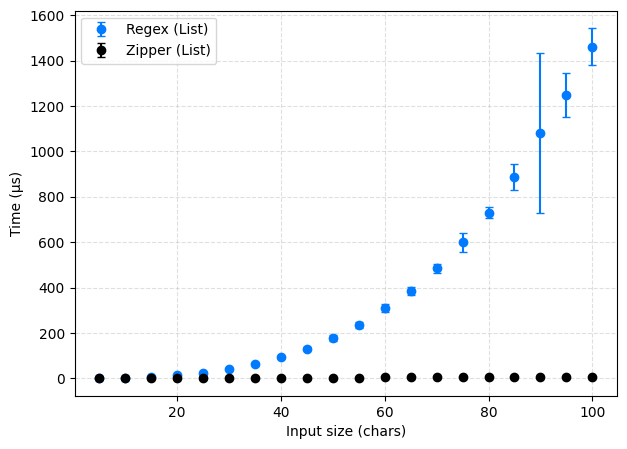

Title:  Regex: ab* Accepting - Zipper vs Memoization Zipper (List)


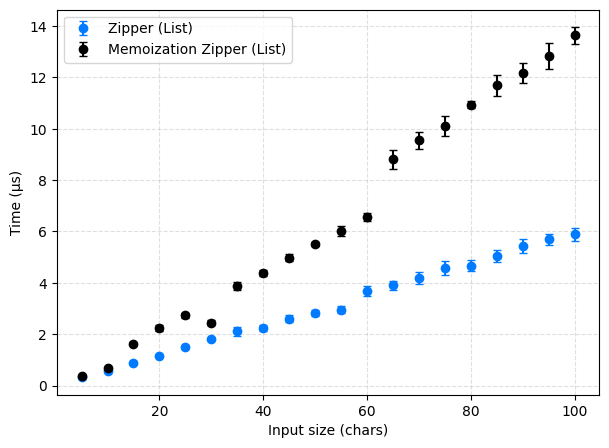

Title:  Regex: ab* Accepting - Zipper (List vs Vector)


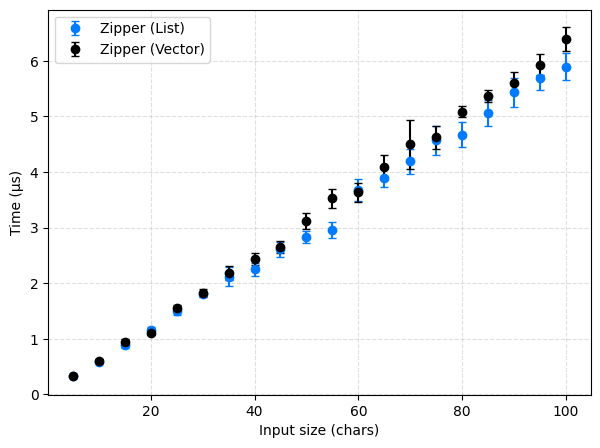

Title:  Regex: ab* Accepting - Zipper (List vs Vector) and Memoization Zipper (Vector)


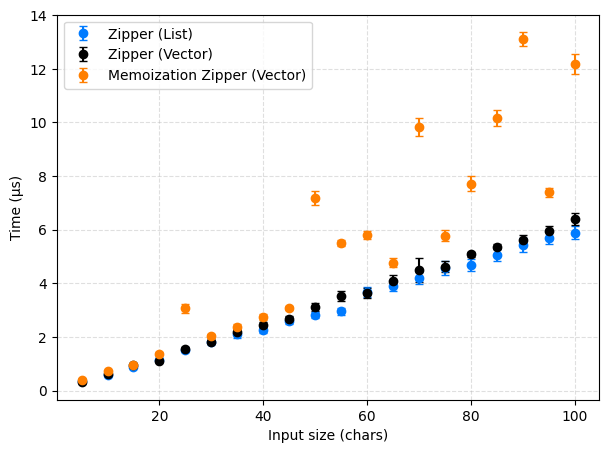

Title:  Regex: Email Accepting - Regex vs Zipper (List)


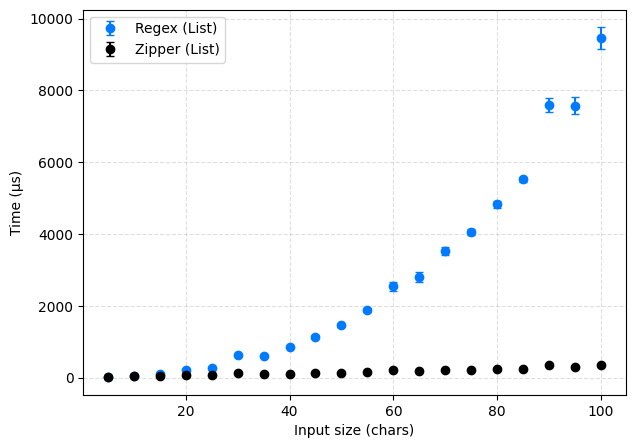

Title:  Regex: Email Accepting - Zipper (List vs Vector)


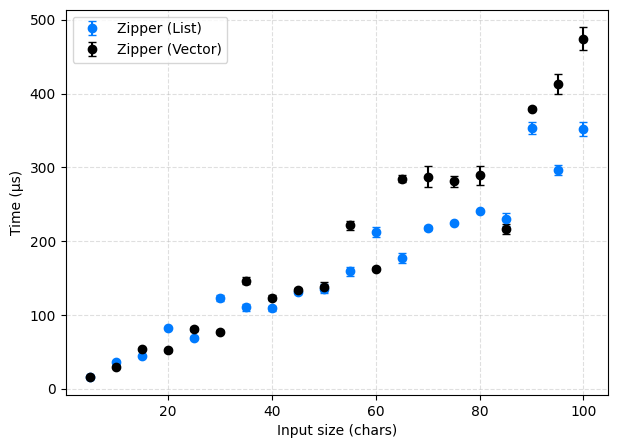

Title:  Regex: Email Accepting - Zipper vs Memoization Zipper (Vector)


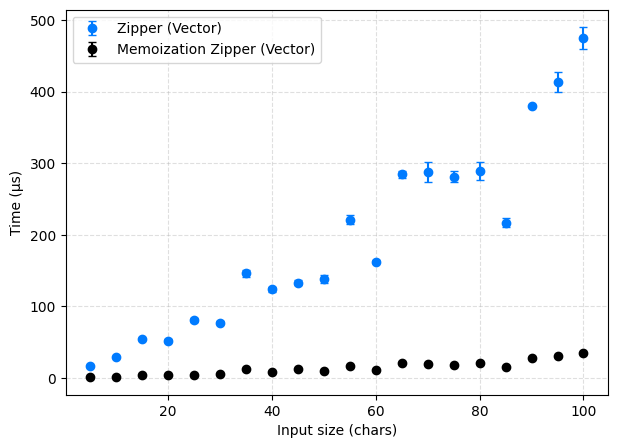

Title:  Regex: Email Accepting - Zipper (List vs Vector) and Memoization Zipper (Vector)


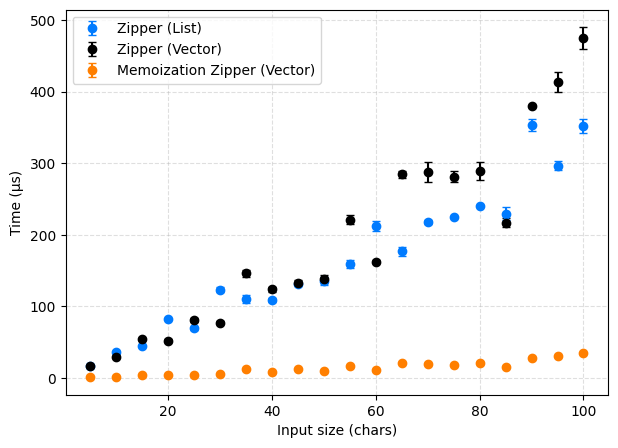

In [8]:
latest_folder = Path("./latest")
regex_benchmark_file = None
for entry in os.listdir(latest_folder):
    if entry.lower().startswith('regex_benchmark'):
        regex_benchmark_file = latest_folder / entry
        break

assert regex_benchmark_file is not None, "Could not find regex benchmark file in 'latest' folder."
with open(regex_benchmark_file, "r") as f:
    raw4 = f.read()
data4 = parse_jmh_table(raw4)

abStarAccepting_Regex_list = "RegexBenchmark.abStarAccepting_Regex_list"
abStarAccepting_ZipperMem_list = "RegexBenchmark.abStarAccepting_ZipperMem_list"
abStarAccepting_ZipperMem_vector = "RegexBenchmark.abStarAccepting_ZipperMem_vector"
abStarAccepting_Zipper_list = "RegexBenchmark.abStarAccepting_Zipper_list"
abStarAccepting_Zipper_vector = "RegexBenchmark.abStarAccepting_Zipper_vector"
emailAccepting_RegexMem_list = "RegexBenchmark.emailAccepting_RegexMem_list"
emailAccepting_Regex_list = "RegexBenchmark.emailAccepting_Regex_list"
emailAccepting_ZipperMem_vector = "RegexBenchmark.emailAccepting_ZipperMem_vector"
emailAccepting_Zipper_list = "RegexBenchmark.emailAccepting_Zipper_list"
emailAccepting_Zipper_vector = "RegexBenchmark.emailAccepting_Zipper_vector"

pretty_labels = {
      abStarAccepting_Regex_list: "Regex (List)",
      abStarAccepting_Zipper_list: "Zipper (List)",
      abStarAccepting_ZipperMem_list: "Memoization Zipper (List)",
      abStarAccepting_Zipper_vector: "Zipper (Vector)",
      abStarAccepting_ZipperMem_vector: "Memoization Zipper (Vector)",
      emailAccepting_Regex_list: "Regex (List)",
      emailAccepting_RegexMem_list: "Memoization Regex (List)",
      emailAccepting_Zipper_list: "Zipper (List)",
      emailAccepting_Zipper_vector: "Zipper (Vector)",
      emailAccepting_ZipperMem_vector: "Memoization Zipper (Vector)",
}

plot2((abStarAccepting_Regex_list, data4[abStarAccepting_Regex_list]),
      (abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      title="Regex: ab* Accepting - Regex vs Zipper (List)",
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      fmt="eps")

plot2((abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      (abStarAccepting_ZipperMem_list, data4[abStarAccepting_ZipperMem_list]),
      title="Regex: ab* Accepting - Zipper vs Memoization Zipper (List)",
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      fmt="eps")

plot2((abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      (abStarAccepting_Zipper_vector, data4[abStarAccepting_Zipper_vector]),
      title="Regex: ab* Accepting - Zipper (List vs Vector)",
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      fmt="eps")

plot3((abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      (abStarAccepting_Zipper_vector, data4[abStarAccepting_Zipper_vector]),
      (abStarAccepting_ZipperMem_vector, data4[abStarAccepting_ZipperMem_vector]),
      title="Regex: ab* Accepting - Zipper (List vs Vector) and Memoization Zipper (Vector)",
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      fmt="eps")

plot2((emailAccepting_Regex_list, data4[emailAccepting_Regex_list]),
      (emailAccepting_Zipper_list, data4[emailAccepting_Zipper_list]),
      title="Regex: Email Accepting - Regex vs Zipper (List)",
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      fmt="eps")

plot2((emailAccepting_Zipper_list, data4[emailAccepting_Zipper_list]),
      (emailAccepting_Zipper_vector, data4[emailAccepting_Zipper_vector]),
      title="Regex: Email Accepting - Zipper (List vs Vector)",
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      fmt="eps")

plot2((emailAccepting_Zipper_vector, data4[emailAccepting_Zipper_vector]),
      (emailAccepting_ZipperMem_vector, data4[emailAccepting_ZipperMem_vector]),
      title="Regex: Email Accepting - Zipper vs Memoization Zipper (Vector)",
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      fmt="eps")

plot3((emailAccepting_Zipper_list, data4[emailAccepting_Zipper_list]),
      (emailAccepting_Zipper_vector, data4[emailAccepting_Zipper_vector]),
      (emailAccepting_ZipperMem_vector, data4[emailAccepting_ZipperMem_vector]),
      title="Regex: Email Accepting - Zipper (List vs Vector) and Memoization Zipper (Vector)",
      pretty_data_labels=pretty_labels,
      # output_folder="plots",
      output_folder=None,
      fmt="eps")


# Lexer Comments Regex Benchmarks

Title:  Single Line Comments Matching
Regex vs Zipper vs Scala Regex (List and Vector, with and w/ Memo)


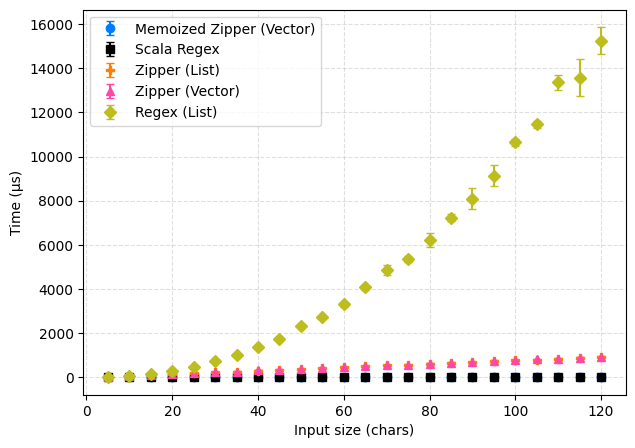

Title:  Single Line Comments
Zipper vs Scala Regex (List and Vector, with and w/ Memoization)


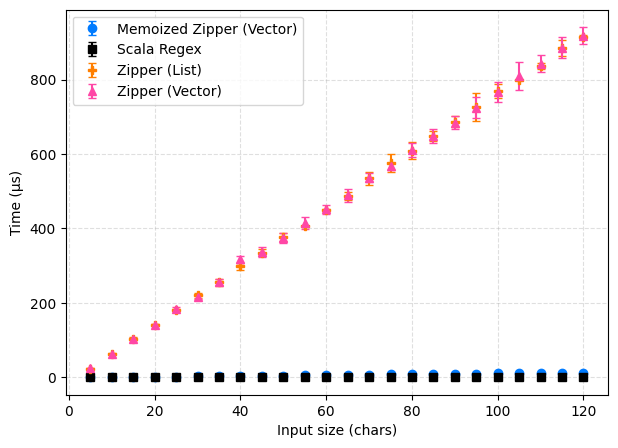

Title:  Single Line Comments
Zipper vs Scala Regex (Vector, with Memoization)


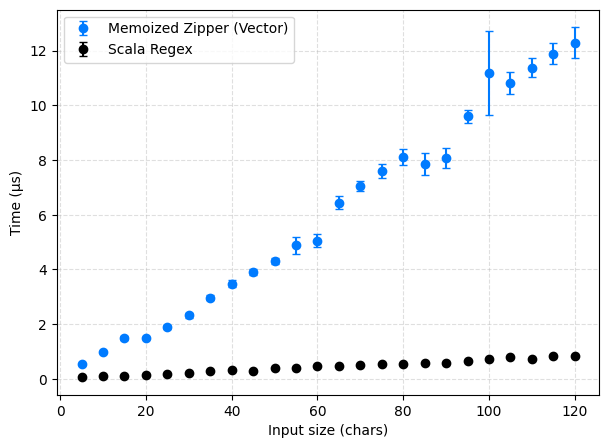

Title:  Single Line Comments Matching
Regex (List) with Polynomial Regression (deg 2)


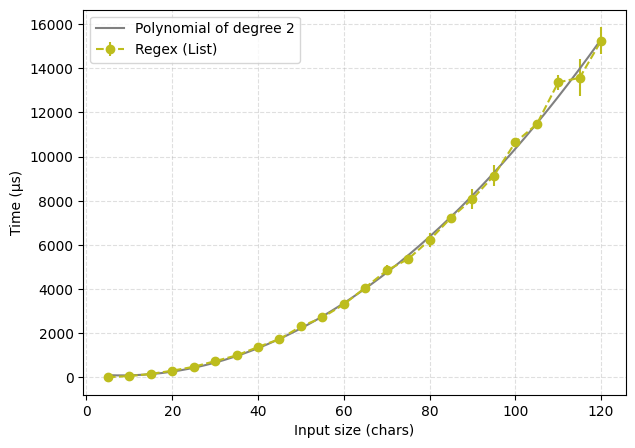

Polynomial function f(x) = 1.216*x^2 - 19.78*x + 171.4
Title:  Single Line Comments Matching
Regex (List) with Polynomial Regression (deg 3)


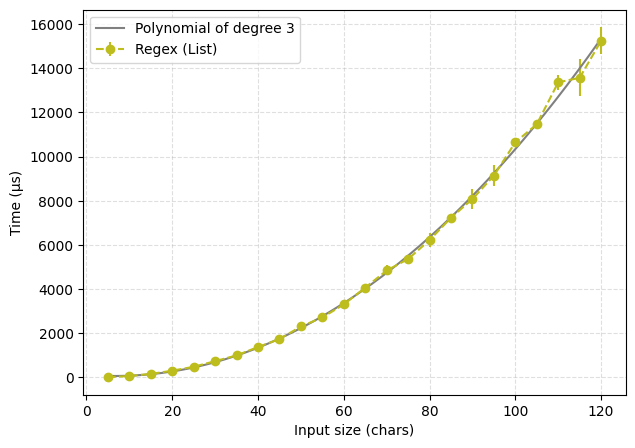

Polynomial function f(x) = 0.0005304*x^3 + 1.117*x^2 - 14.71*x + 113.2
Title:  Single Line Comments Matching
Regex (List) with Polynomial Regression (deg 4)


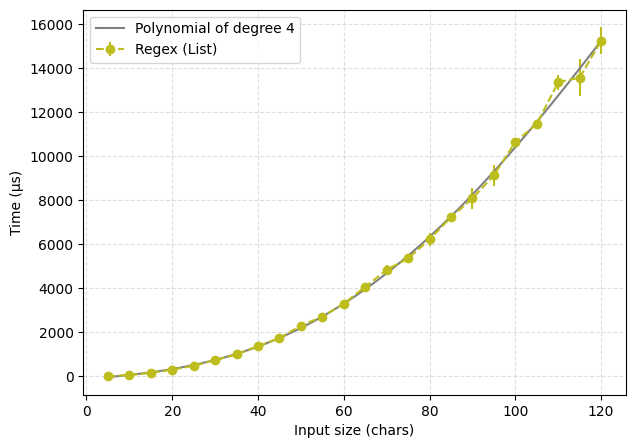

Polynomial function f(x) =  - 5.534e-05*x^4 + 0.01436*x^3 - 0.01063*x^2 + 18.15*x - 129.6
Title:  Multi-line Comments Matching
Regex vs Zipper vs Scala Regex (List and Vector, with and w/ Memo)


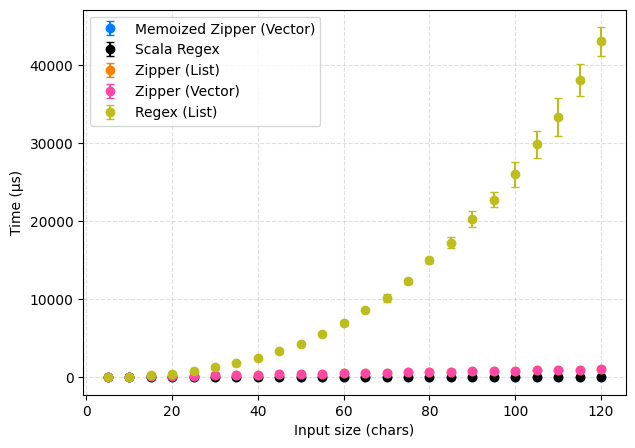

Title:  Multi-line Comments
Zipper vs Scala Regex (List and Vector, with and w/ Memoization)


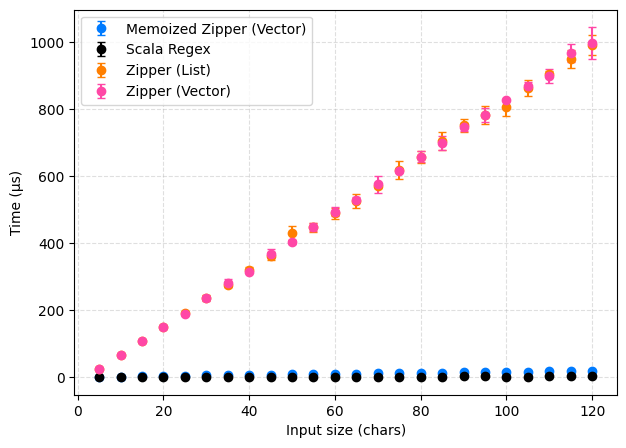

Title:  Multi-line Comments
Zipper vs Scala Regex (Vector, with Memoization)


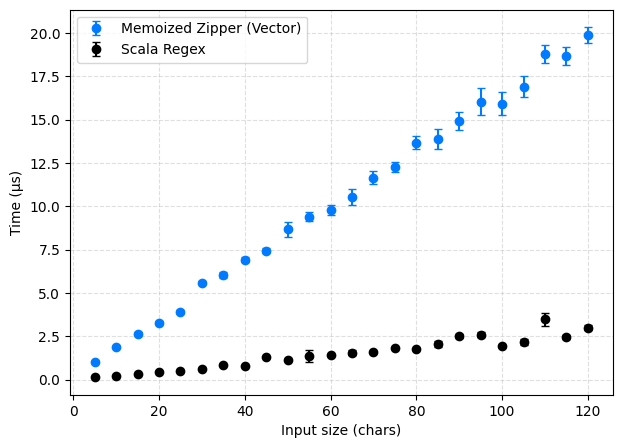

Title:  Multi-line Comments Matching
Regex (List) with Polynomial Regression (deg 3)


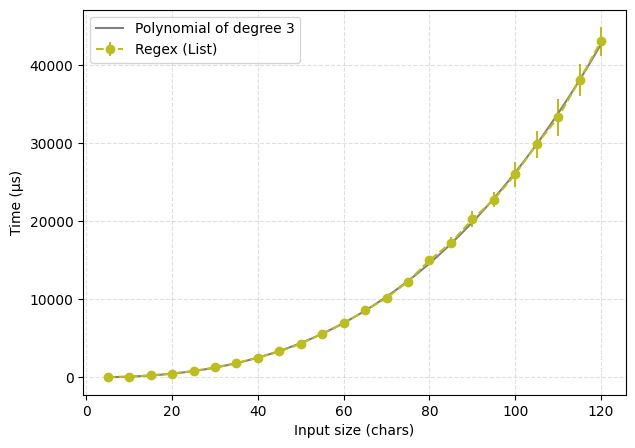

Polynomial function f(x) = 0.01681*x^3 + 0.9682*x^2 - 2.58*x - 5.025


In [9]:
latest_folder = Path("./latest")
regex_benchmark_file = None
for entry in os.listdir(latest_folder):
    if 'lexerregex_benchmark' in entry.lower():
        lexer_regex_benchmark_file = latest_folder / entry
        break

assert lexer_regex_benchmark_file is not None, "Could not find regex benchmark file in 'latest' folder."
with open(lexer_regex_benchmark_file, "r") as f:
    raw5 = f.read()
data5 = parse_jmh_table(raw5)

pretty_labels = {
        "LexerRegexBenchmark.commentAccepting_Regex_list": "Regex (List)",
        "LexerRegexBenchmark.commentAccepting_Regex_multiline_list": "Regex (List)",
        "LexerRegexBenchmark.commentAccepting_ZipperNMem_vector" : "Memoized Zipper (Vector)",
        "LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem": "Memoized Zipper (Vector)",
        "LexerRegexBenchmark.commentAccepting_Zipper_list": "Zipper (List)",
        "LexerRegexBenchmark.commentAccepting_Zipper_multiline_list": "Zipper (List)",
        "LexerRegexBenchmark.commentAccepting_Zipper_vector": "Zipper (Vector)",
        "LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector": "Zipper (Vector)",
        "LexerRegexBenchmark.commentAccepting_scalaRegex": "Scala Regex",
        "LexerRegexBenchmark.commentAccepting_scalaRegex_multiline": "Scala Regex",
}


# Single line comments


plot5(
    ("LexerRegexBenchmark.commentAccepting_ZipperNMem_vector", data5["LexerRegexBenchmark.commentAccepting_ZipperNMem_vector"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex", data5["LexerRegexBenchmark.commentAccepting_scalaRegex"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_list", data5["LexerRegexBenchmark.commentAccepting_Zipper_list"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_vector", data5["LexerRegexBenchmark.commentAccepting_Zipper_vector"]),
    ("LexerRegexBenchmark.commentAccepting_Regex_list", data5["LexerRegexBenchmark.commentAccepting_Regex_list"]),
    title="Single Line Comments Matching\nRegex vs Zipper vs Scala Regex (List and Vector, with and w/ Memo)",
    pretty_data_labels=pretty_labels,
    output_folder="plots",
    shape_cycle=['o', 's', 'P', '^', 'D'],
    fmt="pdf")

plot4(
    ("LexerRegexBenchmark.commentAccepting_ZipperNMem_vector", data5["LexerRegexBenchmark.commentAccepting_ZipperNMem_vector"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex", data5["LexerRegexBenchmark.commentAccepting_scalaRegex"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_list", data5["LexerRegexBenchmark.commentAccepting_Zipper_list"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_vector", data5["LexerRegexBenchmark.commentAccepting_Zipper_vector"]),
    title="Single Line Comments\nZipper vs Scala Regex (List and Vector, with and w/ Memoization)",
    pretty_data_labels=pretty_labels,
    output_folder="plots",
    shape_cycle=['o', 's', 'P', '^', 'D'],
    fmt="pdf")

plot2(("LexerRegexBenchmark.commentAccepting_ZipperNMem_vector", data5["LexerRegexBenchmark.commentAccepting_ZipperNMem_vector"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex", data5["LexerRegexBenchmark.commentAccepting_scalaRegex"]),
    title="Single Line Comments\nZipper vs Scala Regex (Vector, with Memoization)",
    pretty_data_labels=pretty_labels,
    # output_folder="plots",
    output_folder=None,
    fmt="pdf")

deg = 2
plot_with_regression(("LexerRegexBenchmark.commentAccepting_Regex_list", data5["LexerRegexBenchmark.commentAccepting_Regex_list"]),
                     degree=deg,
                     title=f"Single Line Comments Matching\nRegex (List) with Polynomial Regression (deg {deg})",
                     pretty_data_labels=pretty_labels,
                     color=_COLOR_CYCLE[4],
                    #  output_folder="plots",
                     output_folder=None,
                     fmt="pdf")

deg = 3
plot_with_regression(("LexerRegexBenchmark.commentAccepting_Regex_list", data5["LexerRegexBenchmark.commentAccepting_Regex_list"]),
                     degree=deg,
                     title=f"Single Line Comments Matching\nRegex (List) with Polynomial Regression (deg {deg})",
                     pretty_data_labels=pretty_labels,
                     color=_COLOR_CYCLE[4],
                    #  output_folder="plots",
                     output_folder=None,
                     fmt="pdf")

deg = 4
plot_with_regression(("LexerRegexBenchmark.commentAccepting_Regex_list", data5["LexerRegexBenchmark.commentAccepting_Regex_list"]),
                     degree=deg,
                     title=f"Single Line Comments Matching\nRegex (List) with Polynomial Regression (deg {deg})",
                     pretty_data_labels=pretty_labels,
                     color=_COLOR_CYCLE[4],
                    #  output_folder="plots",
                     output_folder=None,
                     fmt="pdf")



# Mutli-line comments

plot5(
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex_multiline", data5["LexerRegexBenchmark.commentAccepting_scalaRegex_multiline"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_list", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_list"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector"]),
    ("LexerRegexBenchmark.commentAccepting_Regex_multiline_list", data5["LexerRegexBenchmark.commentAccepting_Regex_multiline_list"]),
    title="Multi-line Comments Matching\nRegex vs Zipper vs Scala Regex (List and Vector, with and w/ Memo)",
    pretty_data_labels=pretty_labels,
    # output_folder="plots",
    output_folder=None,
    fmt="pdf")

plot4(
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex_multiline", data5["LexerRegexBenchmark.commentAccepting_scalaRegex_multiline"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_list", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_list"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector"]),
    title="Multi-line Comments\nZipper vs Scala Regex (List and Vector, with and w/ Memoization)",
    pretty_data_labels=pretty_labels,
    # output_folder="plots",
    output_folder=None,
    fmt="pdf")

plot2(("LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex_multiline", data5["LexerRegexBenchmark.commentAccepting_scalaRegex_multiline"]),
    title="Multi-line Comments\nZipper vs Scala Regex (Vector, with Memoization)",
    pretty_data_labels=pretty_labels,
    # output_folder="plots",
    output_folder=None,
    fmt="pdf")

plot_with_regression(("LexerRegexBenchmark.commentAccepting_Regex_multiline_list", data5["LexerRegexBenchmark.commentAccepting_Regex_multiline_list"]),
                     degree=3,
                     title="Multi-line Comments Matching\nRegex (List) with Polynomial Regression (deg 3)",
                     pretty_data_labels=pretty_labels,
                     color=_COLOR_CYCLE[4],
                    #  output_folder="plots",
                     output_folder=None,
                     fmt="pdf")


# Coqlex Comparison Benchmark Results

In [10]:
# --- Build { system_name: [(num_chars, time_seconds), ...] } from your results folder ---

from pathlib import Path
import json
from collections import defaultdict

def load_benchmark_dict(base_dir: str | Path) -> dict[str, list[tuple[int, float]]]:
    """
    Walks `base_dir`, where each immediate subfolder is a system (e.g., CoqLex, ZipLex, ...),
    and each contains JSON files with fields:
        {
          "fname": "162.json",
          "input_len": 37599,
          "times": [0.01234],
          "rest_len": 0,
          "sem_tokens_len": "Some 11664"
        }
    Returns:
        dict: { system_name: [(input_len, time_seconds), ...] } sorted by input_len
    """
    base = Path(base_dir).expanduser().resolve()
    if not base.is_dir():
        raise NotADirectoryError(f"'{base}' is not a directory")

    data = defaultdict(list)

    for system_dir in sorted([p for p in base.iterdir() if p.is_dir()]):
        system_name = system_dir.name
        for jf in sorted(system_dir.glob("*.json")):
            try:
                with jf.open("r", encoding="utf-8") as f:
                    obj = json.load(f)
                input_len = int(obj["input_len"])
                times_list = obj.get("times", [])
                if not times_list:
                    continue  # skip if no timing present
                time_seconds = float(times_list[0])  # your pipeline stores seconds already
                data[system_name].append((input_len, (time_seconds, 0.0)))  # no error info available
            except Exception as e:
                # keep going if one file is malformed
                print(f"[warn] Skipping {jf}: {e}")

    # sort each system's tuples by input size for easier plotting later
    for k in list(data.keys()):
        data[k] = sorted(data[k], key=lambda t: t[0])

    return dict(data)

RESULTS_ROOT = "from_coqlex/Comparison/JSON/results"  

bench_dict = load_benchmark_dict(RESULTS_ROOT)

# quick sanity check
for system, pairs in bench_dict.items():
    print(f"{system}: {len(pairs)} entries; first few -> {pairs[:3]}")


CoqLex: 13 entries; first few -> [(456, (0.00013, 0.0)), (5115, (0.00166, 0.0)), (9755, (0.00387, 0.0))]
Verbatim: 13 entries; first few -> [(456, (1.92431, 0.0)), (5115, (2.30765, 0.0)), (9755, (2.64258, 0.0))]
VerbatimSC: 13 entries; first few -> [(456, (1.87321, 0.0)), (5115, (2.22144, 0.0)), (9755, (2.56431, 0.0))]
VerbatimSt: 13 entries; first few -> [(456, (1.904, 0.0)), (5115, (2.2683, 0.0)), (9755, (2.60612, 0.0))]
ZipLex: 13 entries; first few -> [(456, (0.000759784, 0.0)), (5115, (0.010049188, 0.0)), (9755, (0.020559736000000002, 0.0))]
ocamllex: 13 entries; first few -> [(456, (0.0, 0.0)), (5115, (3e-05, 0.0)), (9755, (0.00012, 0.0))]


Title:  JSON Lexing: CoqLex vs ZipLex vs OCamllex vs Verbatim Variants


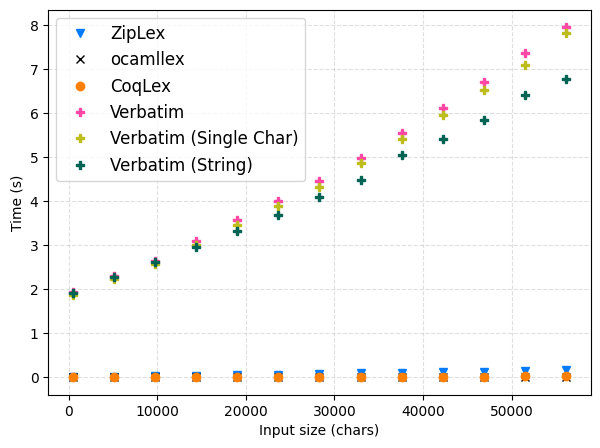

Title:  JSON Lexing: CoqLex vs ZipLex vs OCamllex


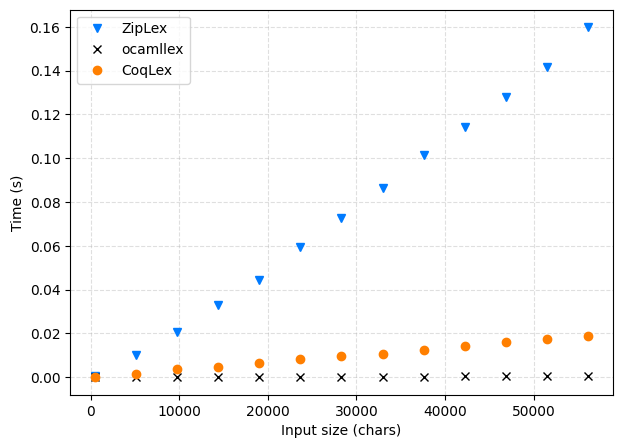

In [11]:
plot6(
    ("ZipLex", bench_dict["ZipLex"]),
    ("ocamllex", bench_dict["ocamllex"]),
    ("CoqLex", bench_dict["CoqLex"]),
    ("Verbatim", bench_dict["Verbatim"]),
    ("VerbatimSC", bench_dict["VerbatimSC"]),
    ("VerbatimSt", bench_dict["VerbatimSt"]),
    title="JSON Lexing: CoqLex vs ZipLex vs OCamllex vs Verbatim Variants",
    pretty_data_labels={
        "CoqLex": "CoqLex",
        "Verbatim": "Verbatim",
        "VerbatimSC": "Verbatim (Single Char)",
        "VerbatimSt": "Verbatim (String)",
        "ZipLex": "ZipLex",
        "ocamllex": "ocamllex"
    },
    shape_cycle= [
        'v',
        'x',
        'o',
        'P',
        'P',
        'P',
    ],
    time_unit="s",
    output_folder="plots",
    fmt="pdf",
    fontsize=12,
    error_bars=False
)

plot3(
    ("ZipLex", bench_dict["ZipLex"]),
    ("ocamllex", bench_dict["ocamllex"]),
    ("CoqLex", bench_dict["CoqLex"]),
    title="JSON Lexing: CoqLex vs ZipLex vs OCamllex",
    pretty_data_labels={
        "CoqLex": "CoqLex",
        "Verbatim": "Verbatim",
        "VerbatimSC": "Verbatim (Single Char)",
        "VerbatimSt": "Verbatim (String)",
        "ZipLex": "ZipLex",
        "ocamllex": "ocamllex"
    },
    shape_cycle= [
        'v',
        'x',
        'o',
        'P',
        'P',
        'P',
    ],
    time_unit="s",
    # output_folder="plots",
    output_folder=None,
    fmt="pdf",
    error_bars=False
)

# A and A*B Lexer Benchmark Results

In [12]:
# --- Flex (hyperfine) JSON ingestion: latest/flex/*.json -> list[(size, (mean, err_99_9_ci))] ---

from pathlib import Path
import json
import math
import re

FLEX_DIR = Path("latest/flex")  # adjust if needed
assert FLEX_DIR.exists(), f"Flex results folder not found: {FLEX_DIR.resolve()}"

# Unit scaling: hyperfine reports seconds. Set to 1e6 for microseconds, 1e3 for ms, 1 for seconds.
SCALE = 1e6
UNIT = "µs"

# 99.9% two-sided CI => alpha = 0.001
ALPHA = 0.001

def _t_crit_2sided_999(df: int) -> float:
    """
    Two-sided 99.9% t critical value with df degrees of freedom.
    Uses SciPy if available; otherwise falls back to normal approx (conservative-ish for df>=9).
    """
    try:
        from scipy.stats import t  # type: ignore
        return float(t.ppf(1 - ALPHA / 2, df))
    except Exception:
        # Normal approx for 99.9% two-sided
        return 3.290526731

def _parse_size_from_name(p: Path) -> int:
    # expects flex_<size>.json, where <size> may be "500" or "500.0"
    m = re.match(r"flex_(.+)\.json$", p.name)
    if not m:
        raise ValueError(f"Unexpected filename: {p.name}")
    s = float(m.group(1))
    return int(s) if s.is_integer() else int(round(s))

flex_results = []  # list[(size, (mean, err))]
flex_results_dict = {}  # dict[size] = (mean, err)

for jp in sorted(FLEX_DIR.glob("flex_*.json")):
    with open(jp, "r") as f:
        payload = json.load(f)

    r = payload["results"][0]
    times = r.get("times", [])
    n = len(times) if times else None

    mean_s = float(r["mean"])
    std_s = float(r.get("stddev", 0.0))

    # If stddev missing/zero but we have times, compute sample stddev.
    if (std_s == 0.0) and times and len(times) >= 2:
        m = sum(times) / len(times)
        var = sum((x - m) ** 2 for x in times) / (len(times) - 1)
        std_s = math.sqrt(var)

    # 99.9% CI half-width: t * s / sqrt(n)
    if times and len(times) >= 2:
        tcrit = _t_crit_2sided_999(len(times) - 1)
        err_s = tcrit * std_s / math.sqrt(len(times))
    else:
        err_s = float("nan")

    size = _parse_size_from_name(jp)
    mean = mean_s * SCALE
    err = err_s * SCALE

    flex_results.append((size, (mean, err)))
    flex_results_dict[size] = (mean, err)

flex_results.sort(key=lambda x: x[0])

print(f"Loaded {len(flex_results)} flex JSON files from {FLEX_DIR.resolve()}")
print(f"Units: {UNIT} (SCALE={SCALE})")
flex_results


Loaded 48 flex JSON files from /Users/samuel/EPFL/bolts/lexers/regex/verifiedlexer/benchmark_results/latest/flex
Units: µs (SCALE=1000000.0)


[(100, (583.38746, 43.80073828878326)),
 (200, (652.5369199999999, 46.69660476866841)),
 (300, (1056.3289399999999, 657.138771519615)),
 (500, (471.5713199999998, 19.83252576292452)),
 (500, (1569.9765, 693.6588746512797)),
 (800, (2457.22116, 709.3894522514316)),
 (1000, (3056.00886, 215.1664514776957)),
 (1200, (4512.7609600000005, 937.2292711633806)),
 (2000, (10495.981780000002, 128.18781888359229)),
 (2500, (16922.516539999997, 649.3592869883214)),
 (5000, (63513.62358, 617.970195339878)),
 (10000, (245802.04025999998, 378.0607264750748)),
 (12500, (382007.63791999995, 596.1999511025425)),
 (15000, (549677.28656, 1264.9473885948676)),
 (17500, (746665.1755799999, 1054.2194047923274)),
 (20000, (974112.1994599998, 1984.6307230642224)),
 (22500, (1232236.8424, 2637.463873886325)),
 (25000, (1519477.9643200003, 1868.7925178529356)),
 (27500, (1838165.1545199999, 1781.0163651404332)),
 (30000, (2186321.23716, 642.2043889690821)),
 (32500, (2566412.9117199997, 2398.218205333544)),
 (35

In [13]:
# Load coqles a and a*b results

RESULTS_ROOT_AASTARB = "from_coqlex/Comparison/AAStarB/results"
res = load_benchmark_dict(RESULTS_ROOT_AASTARB)
coqlex_aastar_b = res["CoqLex"]
verbatim_aastar_b = res["Verbatim"]

# Convert time in seconds to µs
coqlex_aastar_b = [(size, (time_sec * 1e6, err * 1e6)) for size, (time_sec, err) in coqlex_aastar_b]
print(f"coqlex_aastar_b: {coqlex_aastar_b}")
verbatim_aastar_b = [(size, (time_sec * 1e6, err * 1e6)) for size, (time_sec, err) in verbatim_aastar_b]
print(f"verbatim_aastar_b: {verbatim_aastar_b}")

coqlex_aastar_b: [(100, (110.0, 0.0)), (200, (490.0, 0.0)), (300, (1120.0, 0.0)), (500, (3020.0, 0.0)), (800, (8280.0, 0.0)), (1000, (12620.0, 0.0)), (1200, (18280.0, 0.0)), (2000, (52260.0, 0.0)), (2500, (79760.0, 0.0)), (5000, (327760.0, 0.0)), (10000, (1369000.0, 0.0)), (12500, (2195910.0, 0.0)), (15000, (3226130.0, 0.0)), (17500, (4604760.0, 0.0)), (20000, (6166070.0, 0.0)), (22500, (7918900.0, 0.0)), (25000, (10400190.0, 0.0)), (27500, (13104360.0, 0.0)), (30000, (15415130.0, 0.0)), (32500, (18883020.0, 0.0)), (35000, (22235750.0, 0.0)), (37500, (26058840.0, 0.0)), (40000, (30953010.0, 0.0)), (42500, (34901260.0, 0.0)), (45000, (39498200.0, 0.0)), (47500, (46065530.0, 0.0)), (50000, (50357560.0, 0.0)), (52500, (57909380.0, 0.0)), (55000, (65194390.0, 0.0)), (57500, (72588140.0, 0.0)), (60000, (78408690.0, 0.0)), (62500, (85915110.0, 0.0)), (65000, (94846540.0, 0.0)), (67500, (108986120.0, 0.0)), (70000, (113958010.0, 0.0)), (72500, (127383140.0, 0.0)), (75000, (138069750.0, 0.0)),

dict_keys(['AAStarBLexerBenchmark.lex_Silex', 'AAStarBLexerBenchmark.lex_ZipperV3Mem'])
Title:  a & a*b: ZipLex with Linear Regression (deg 1)


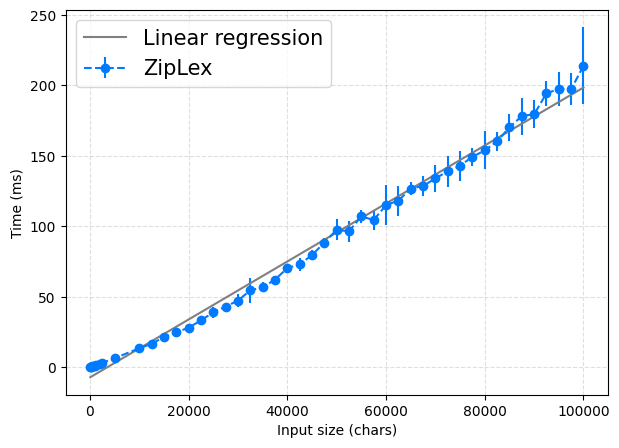

Polynomial function f(x) = 0.00206*x - 7.488
Title:  a & a*b: ZipLex vs Flex


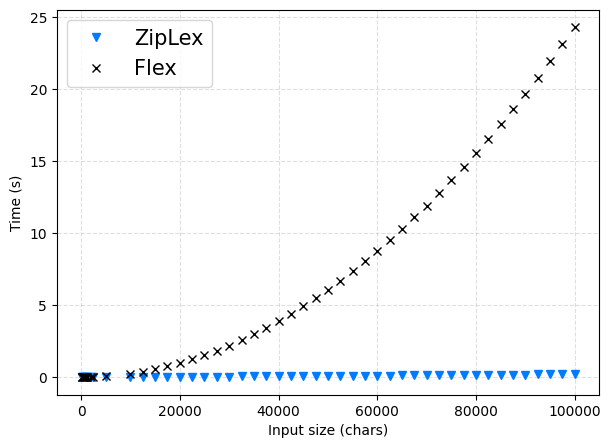

Title:  a & a*b: ZipLex vs Flex vs Coqlex vs Silex


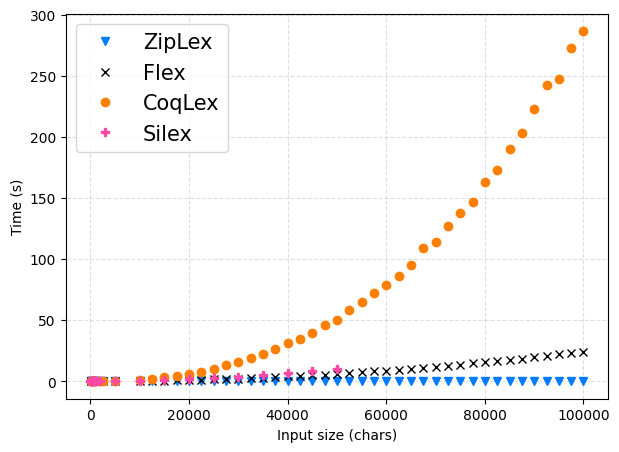

Title:  a & a*b: ZipLex vs Flex vs Coqlex vs Verbatim


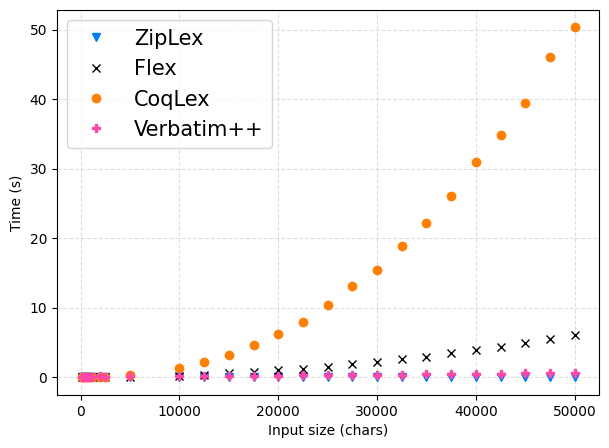

Title:  a & a*b: ZipLex vs Flex vs Coqlex


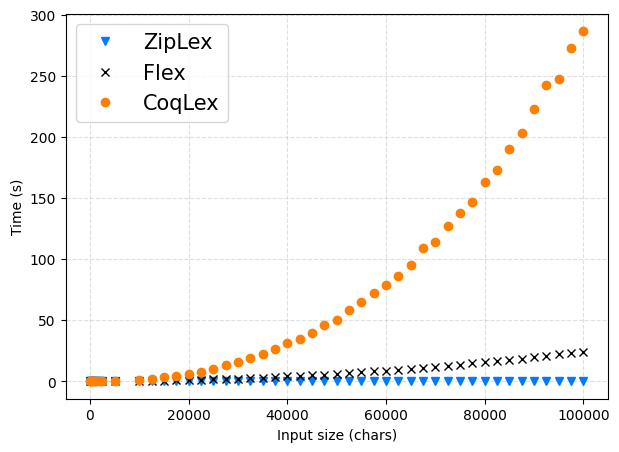

Title:  Flex: Lexing with Quadratic Regression (deg 2)


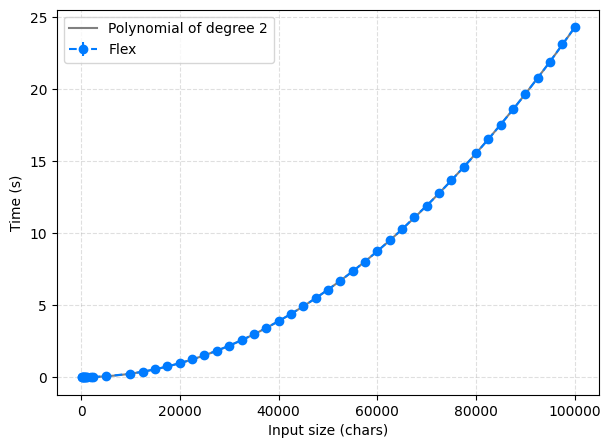

Polynomial function f(x) = 2.426e-09*x^2 + 1.339e-07*x + 0.0009463
Title:  a & a*b: ZipLex vs Verbatim


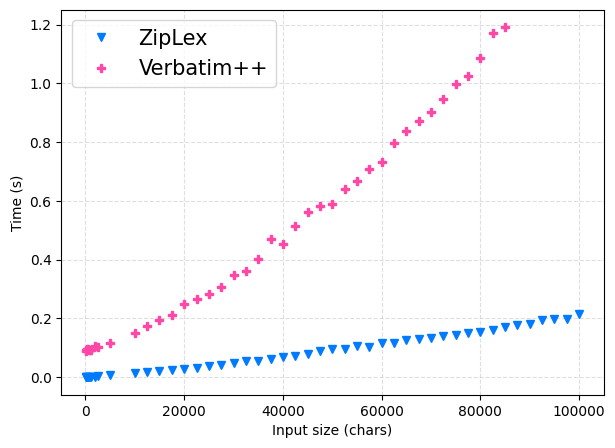

Title:  a & a*b: Verbatim++ with quadratic (deg 2) regression


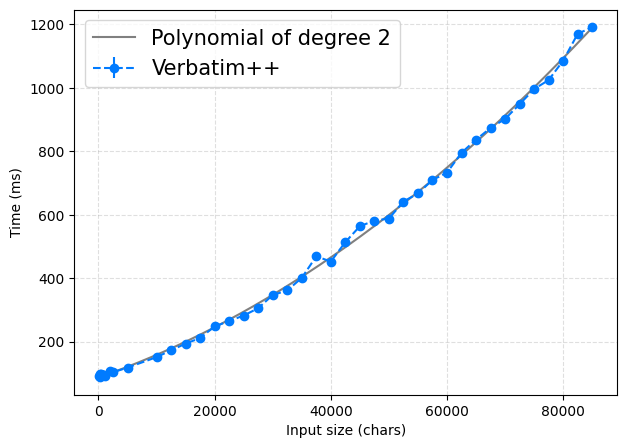

Polynomial function f(x) = 7.8e-08*x^2 + 0.006342*x + 87.22
Title:  a & a*b: Verbatim++ with linear (deg 1) regression


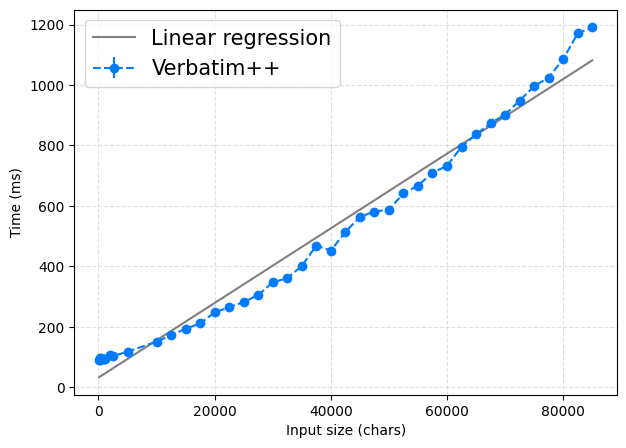

Polynomial function f(x) = 0.01234*x + 32.3
Title:  a & a*b: Verbatim++ with n log n regression


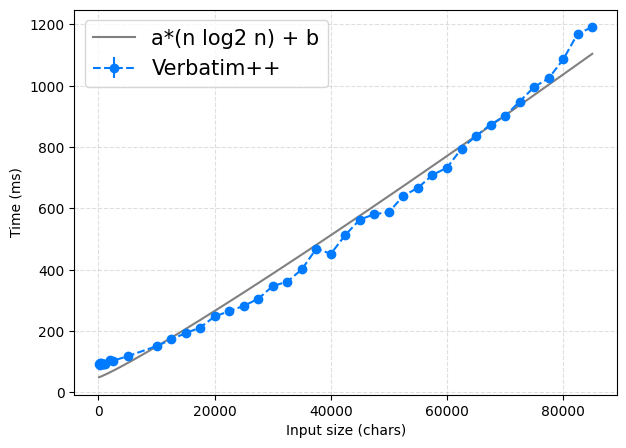

Polynomial function f(x) = 0.0007581*x + 49.23


In [14]:
latest_folder = Path("./latest")
aastarb_lexer_file = None
for entry in os.listdir(latest_folder):
    if 'aa_star_b_lexer_benchmark_wi' in entry.lower():
        aastarb_lexer_file = latest_folder / entry
        break
    
assert aastarb_lexer_file is not None, "Could not find aastarb_lexer benchmark file in 'latest' folder."

with open(aastarb_lexer_file, "r") as f:
    raw6 = f.read()
data6 = parse_jmh_table(raw6)
print(data6.keys())

bench_aastarb_zipperMem = "AAStarBLexerBenchmark.lex_ZipperV3Mem"
bench_aastarb_zipperV1Mem = "AAStarBLexerBenchmark.lex_ZipperV1Mem"
bench_aastarb_zipperMemV2 = "AAStarBLexerBenchmark.lex_ZipperV2Mem"
bench_aastarb_silex = "AAStarBLexerBenchmark.lex_Silex"

# if bench_aastarb_zipperMem in data6 and bench_aastarb_zipperV1Mem in data6 and bench_aastarb_zipperMemV2OnlyDeriv in data6:
d_aastarb_zipperMem = (bench_aastarb_zipperMem, data6[bench_aastarb_zipperMem])
plot_with_regression(d_aastarb_zipperMem,
                        degree=1,
                        title="a & a*b: ZipLex with Linear Regression (deg 1)",
                        show_title=False,
                        # output_folder="plots",
                        output_folder=None,
                        pretty_data_labels={
                            bench_aastarb_zipperMem: "ZipLex"
                        },
                        time_unit="ms",
                        convert_data_from_micro_sec=True,
                        fmt="pdf",
                        fontsize=15)


d_flex = ("flex", flex_results)
d_coqlex_aastar_b = ("CoqLex_AAStarB", coqlex_aastar_b)
d_verbatim_aastar_b = ("Verbatim_AAStarB", verbatim_aastar_b)
d_silex = (bench_aastarb_silex, data6[bench_aastarb_silex])


plot2(
    d_aastarb_zipperMem,
    d_flex,
    title="a & a*b: ZipLex vs Flex",
    show_title=False,
    pretty_data_labels={
        bench_aastarb_zipperMem: "ZipLex",
        "flex": "Flex"
    },
    time_unit="s",
    convert_data_from_micro_sec=True,
    output_folder="plots",
    # output_folder=None,
    fmt="pdf",
    fontsize=15,
    shape_cycle= [
        'v',
        'x',
        'o',
        'P',
        'P',
        'P',
    ],
    error_bars=False,

)

plot4(
    d_aastarb_zipperMem,
    d_flex,
    d_coqlex_aastar_b,
    d_silex,
    title="a & a*b: ZipLex vs Flex vs Coqlex vs Silex",
    show_title=False,
    pretty_data_labels={
        bench_aastarb_zipperMem: "ZipLex",
        "CoqLex_AAStarB": "CoqLex",
        "flex": "Flex",
        bench_aastarb_silex: "Silex"
    },
    time_unit="s",
    convert_data_from_micro_sec=True,
    # output_folder="plots",
    output_folder=None,
    fontsize=15,
    fmt="pdf",
    shape_cycle= [
        'v',
        'x',
        'o',
        'P',
        'P',
        'P',
    ],
    error_bars=False
)

d_aastarb_zipperMem_up_to_50k = (d_aastarb_zipperMem[0], [(size, t) for size, t in d_aastarb_zipperMem[1] if size <= 50000])
d_flex_up_to_50k = (d_flex[0], [(size, t) for size, t in d_flex[1] if size <= 50000])
d_coqlex_aastar_b_up_to_50k = (d_coqlex_aastar_b[0], [(size, t) for size, t in d_coqlex_aastar_b[1] if size <= 50000])
d_verbatim_aastar_b_up_to_50k = (d_verbatim_aastar_b[0], [(size, t) for size, t in d_verbatim_aastar_b[1] if size <= 50000])

plot4(
    d_aastarb_zipperMem_up_to_50k,
    d_flex_up_to_50k,
    d_coqlex_aastar_b_up_to_50k,
    d_verbatim_aastar_b_up_to_50k,
    title="a & a*b: ZipLex vs Flex vs Coqlex vs Verbatim",
    show_title=False,
    pretty_data_labels={
        bench_aastarb_zipperMem: "ZipLex",
        "CoqLex_AAStarB": "CoqLex",
        "flex": "Flex",
        "Verbatim_AAStarB": "Verbatim++",
        bench_aastarb_silex: "Silex"
    },
    time_unit="s",
    convert_data_from_micro_sec=True,
    output_folder="plots",
    fontsize=15,
    # output_folder=None,
    fmt="pdf",
    shape_cycle= [
        'v',
        'x',
        'o',
        'P',
        'P',
        'P',
    ],
    error_bars=False
)

plot3(
    d_aastarb_zipperMem,
    d_flex,
    d_coqlex_aastar_b,
    title="a & a*b: ZipLex vs Flex vs Coqlex",
    show_title=False,
    pretty_data_labels={
        bench_aastarb_zipperMem: "ZipLex",
        "CoqLex_AAStarB": "CoqLex",
        "flex": "Flex",
        bench_aastarb_silex: "Silex"
    },
    time_unit="s",
    convert_data_from_micro_sec=True,
    output_folder="plots",
    fmt="pdf",
    fontsize=15,
    shape_cycle= [
        'v',
        'x',
        'o',
        'P',
        'P',
        'P',
    ],
    error_bars=False
)

plot_with_regression(d_flex,
                        degree=2,
                        title="Flex: Lexing with Quadratic Regression (deg 2)",
                        show_title=False,
                        # output_folder="plots",
                        output_folder=None,
                        pretty_data_labels={
                            "flex": "Flex"
                        },
                        time_unit="s",
                        convert_data_from_micro_sec=True,
                        fmt="pdf")

plot2(
    d_aastarb_zipperMem,
    d_verbatim_aastar_b,
    title="a & a*b: ZipLex vs Verbatim",
    show_title=False,
    pretty_data_labels={
        bench_aastarb_zipperMem: "ZipLex",
        "Verbatim_AAStarB": "Verbatim++"
    },
    time_unit="s",
    convert_data_from_micro_sec=True,
    output_folder="plots",
    fmt="pdf",
    fontsize=15,
    shape_cycle= [
        'v',
        'P',
    ],
    error_bars=False,
    color_cycle=[
    "#007bff",  # blue
    "#ff47a6",  # pink
]
)

plot_with_regression(d_verbatim_aastar_b,
                        degree=2,
                        title="a & a*b: Verbatim++ with quadratic (deg 2) regression",
                        show_title=False,
                        # output_folder="plots",
                        output_folder=None,
                        fontsize=15,
                        pretty_data_labels={
                            bench_aastarb_zipperMem: "ZipLex",
                            "Verbatim_AAStarB": "Verbatim++"
                        },
                        time_unit="ms",
                        convert_data_from_micro_sec=True,
                        fmt="pdf")

plot_with_regression(d_verbatim_aastar_b,
                        degree=1,
                        title="a & a*b: Verbatim++ with linear (deg 1) regression",
                        show_title=False,
                        # output_folder="plots",
                        output_folder=None,
                        fontsize=15,
                        pretty_data_labels={
                            bench_aastarb_zipperMem: "ZipLex",
                            "Verbatim_AAStarB": "Verbatim++"
                        },
                        time_unit="ms",
                        convert_data_from_micro_sec=True,
                        fmt="pdf")

plot_with_regression(d_verbatim_aastar_b,
                        degree="nlogn",
                        title="a & a*b: Verbatim++ with n log n regression",
                        show_title=False,
                        # output_folder="plots",
                        output_folder=None,
                        fontsize=15,
                        pretty_data_labels={
                            bench_aastarb_zipperMem: "ZipLex",
                            "Verbatim_AAStarB": "Verbatim++"
                        },
                        time_unit="ms",
                        convert_data_from_micro_sec=True,
                        fmt="pdf")


# plot2(
#     d_aastarb_zipperMem,
#     (bench_aastarb_zipperV1Mem, data6[bench_aastarb_zipperV1Mem]),
#     title="AAStarB: Lexing Variants Comparison",
#     show_title=False,
#     pretty_data_labels={
#         bench_aastarb_zipperMem: "Zipper V3 with Memoization",
#         bench_aastarb_zipperV1Mem: "Zipper V1 with Memoization",
#     },
#     output_folder="plots",
#     fmt="pdf"
# )
# plot2(
#     d_aastarb_zipperMem,
#     (bench_aastarb_zipperMemV2, data6[bench_aastarb_zipperMemV2]),
#     title="AAStarB: Lexing Variants Comparison",
#     show_title=False,
#     pretty_data_labels={
#         bench_aastarb_zipperMem: "Zipper V3 with Memoization",
#         bench_aastarb_zipperMemV2: "Zipper V2 with Memoization",
#     },
#     output_folder="plots",
#     fmt="pdf"
# )
# else:
#     print(f"Benchmark {bench_aastarb_zipperMem} not found in the latest data.")

In [15]:
def generate_file_containing_N_characters_a(n: int, directory_path):
    """Generate a file containing 'a' repeated n times."""
    directory = Path(directory_path)
    directory.mkdir(parents=True, exist_ok=True)
    file_path = directory / f"{n}.txt"
    with open(file_path, "w") as f:
        for i in range(n):
          f.write('a')
    return file_path


directory = "/Users/samuel/EPFL/bolts/lexers/regex/verifiedlexer/src/main/scala/com/ziplex/benchmark/res/as"

sizes: list[int] = [int(x * 1000) for x in [0.5, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]]

print(sizes)
for size in sizes:
    generate_file_containing_N_characters_a(size, directory)


[500, 1000, 2000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]


## A and A*B Benchmark for Big Files

Title:  a & a*b (large files): Lexing with Linear Regression (deg 1)


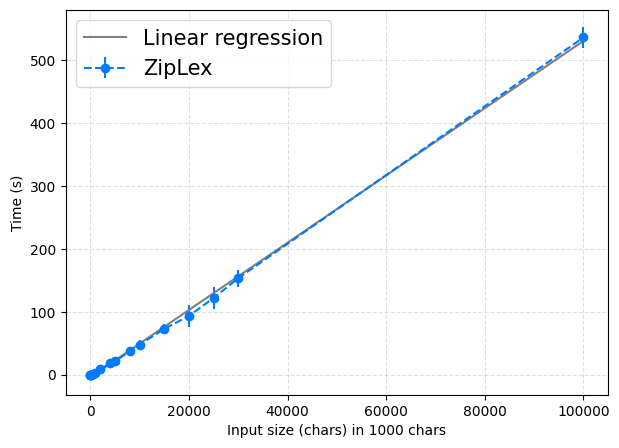

Polynomial function f(x) = 0.005349*x - 4.089
('BigAAStarBLexerBenchmark.lex_ZipperV3Mem', [(10, (13618.183, 1456.581)), (20, (28393.688, 2574.051)), (50, (90501.61, 8635.683)), (100, (199473.117, 10090.797)), (500, (1364261.561, 440497.343)), (1000, (2665155.461, 207479.254)), (2000, (8555999.271, 753853.582)), (4000, (18021313.928, 3253497.198)), (5000, (21411091.775, 5042966.034)), (8000, (36948461.53, 7338245.676)), (10000, (47740424.069, 7081324.299)), (15000, (72795439.667, 7811372.152)), (20000, (93420820.499, 17707414.567)), (25000, (121999471.018, 17059465.16)), (30000, (153450036.344, 13406485.622))])
Title:  a & a*b (large files): Lexing with Linear Regression (deg 1)


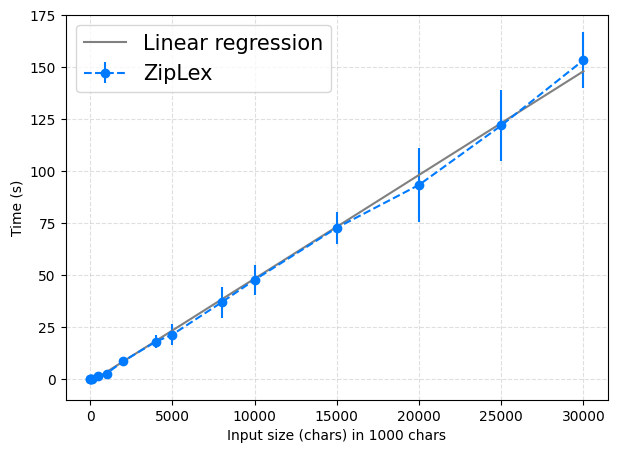

Polynomial function f(x) = 0.004988*x - 1.553


In [16]:
latest_folder = Path("./latest")
aastarb_big_lexer_file = None
for entry in os.listdir(latest_folder):
    if 'aa_star_b_lexer_benchmark_big' in entry.lower():
        aastarb_big_lexer_file = latest_folder / entry
        break
    
assert aastarb_big_lexer_file is not None, "Could not find aastarb_lexer benchmark file in 'latest' folder."
with open(aastarb_big_lexer_file, "r") as f:
    raw7 = f.read()
data7 = parse_jmh_table(raw7)
bench_aastarb_zipperMem = "BigAAStarBLexerBenchmark.lex_ZipperV3Mem"
d_aastarb_big_zipperMem_up_to_30_000KB = (bench_aastarb_zipperMem, [v for v in data7[bench_aastarb_zipperMem] if v[0] <= 30_000])

if bench_aastarb_zipperMem in data7:
    d_aastarb_big_zipperMem = (bench_aastarb_zipperMem, data7[bench_aastarb_zipperMem])
    plot_with_regression(d_aastarb_big_zipperMem,
                         degree=1,
                         title="a & a*b (large files): Lexing with Linear Regression (deg 1)",
                         show_title=False,
                        #  output_folder="plots",
                         output_folder=None,
                         pretty_data_labels={
                             bench_aastarb_zipperMem: "ZipLex"
                         },
                         fmt="pdf",
                         time_unit="s",
                         convert_data_from_micro_sec=True,
                         custom_additional_y_label=" in 1000 chars",
                         fontsize=15
                         )
    
    print(d_aastarb_big_zipperMem_up_to_30_000KB)
    plot_with_regression(d_aastarb_big_zipperMem_up_to_30_000KB,
                         degree=1,
                         title="a & a*b (large files): Lexing with Linear Regression (deg 1)",
                         show_title=False,
                         output_folder="plots",
                         pretty_data_labels={
                             bench_aastarb_zipperMem: "ZipLex"
                         },
                         fmt="pdf",
                         time_unit="s",
                         convert_data_from_micro_sec=True,
                         custom_additional_y_label=" in 1000 chars",
                         fontsize=15
                         )
    
else:
    print(f"Benchmark {bench_aastarb_zipperMem} not found in the latest data.")

In [17]:
# data6[bench_aastarb_zipperV1Mem]

# Stainless verification

In [18]:
verif_report_file = None
for entry in os.listdir(latest_folder):
    if 'verification-report' in entry.lower():
        verif_report_file = latest_folder / entry
        break
  
assert verif_report_file is not None, "Could not find verification report file in 'latest' folder."
with open(verif_report_file, "r") as f:
    verif_report = json.load(f)
  

def get_smt_solver(vc: dict) -> Optional[str]:
    """Extract the SMT solver used from the verification condition dictionary."""
    if "solverName" not in vc or vc["solverName"] is None:
        return None
    return vc["solverName"].replace("U:", "").replace("smt-", "")
def get_smt_id(vc: dict) -> str:
    """Extract the SMT solver ID from the verification condition dictionary."""
    return vc["smtId"]
def get_time_ms(vc: dict) -> float:
    """Extract the time taken (in milliseconds) from the verification condition dictionary."""
    return vc["time"]
def get_time_s(vc: dict) -> float:
    """Extract the time taken (in seconds) from the verification condition dictionary."""
    return vc["time"] / 1000.0
def get_status(vc: dict) -> str:
    """Extract the status of the verification condition."""
    return list(vc["status"].keys())[0].lower()

def filter_out_smt_queries(vcs: list[dict], smt_queries_directory: str):
    """
    Goes through the smt-lib files in smt_queries_directory and removes smt queries that are not
    for the solver that solved the VC. We need to do this because the solvers are run in parallel, 
    and we want to keep only the smt lib files for the solver that solved the VC.
    """
    smt_id_to_solver = {}
    for vc in vcs:
        smt_id = get_smt_id(vc)
        solver = get_smt_solver(vc)
        smt_id_to_solver[smt_id] = solver
    
    # go through the directory
    for file_name in os.listdir(smt_queries_directory):
        if file_name.endswith(".smt2"):
            smt_id_in_file = int(file_name.split("-")[-1].replace(".smt2", ""))
            if smt_id_in_file in smt_id_to_solver:
                solver_for_vc = smt_id_to_solver[smt_id_in_file]
                if solver_for_vc.lower() not in file_name.lower():
                    # delete the file
                    os.remove(os.path.join(smt_queries_directory, file_name))
            else:
                print(f"SMT ID {smt_id_in_file} not found in VCs.")
                os.remove(os.path.join(smt_queries_directory, file_name))



vcs = verif_report["stainless"][0][1][0]
filter_out_smt_queries(vcs, "./latest/smt-sessions-filtered")
print(f"After filtering: {len(os.listdir('./latest/smt-sessions-filtered'))}")

    

After filtering: 0


Total number of VCs: 24217
Number of trivial VCs: 333
Number of valid from cache VCs: 9168
Number of valid VCs: 14716
Title:  Distribution of Verification Times for VCs


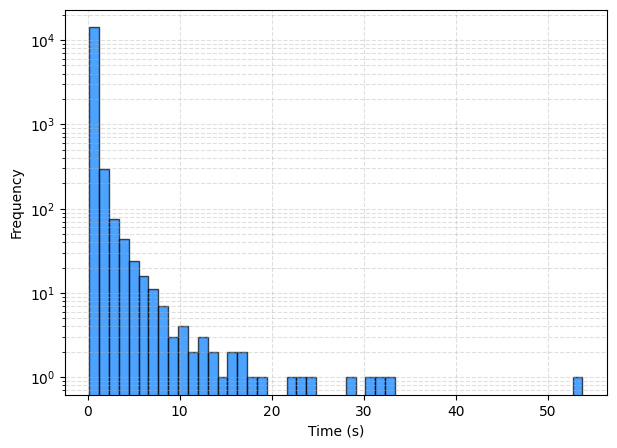

Number of valid VCs slower than 10s: 25



SMT ID: 1360, Solver: cvc5, Time (s): 30.381
SMT ID: 1361, Solver: z3, Time (s): 10.543
SMT ID: 1253, Solver: cvc5, Time (s): 33.095
SMT ID: 2281, Solver: cvc5, Time (s): 31.761
SMT ID: 3438, Solver: cvc5, Time (s): 18.871
SMT ID: 3439, Solver: cvc5, Time (s): 22.135
SMT ID: 2627, Solver: z3, Time (s): 10.597
SMT ID: 2628, Solver: z3, Time (s): 12.092
SMT ID: 2630, Solver: z3, Time (s): 10.008
SMT ID: 2632, Solver: z3, Time (s): 11.602
SMT ID: 2610, Solver: z3, Time (s): 13.536
SMT ID: 2613, Solver: z3, Time (s): 12.727
SMT ID: 2614, Solver: z3, Time (s): 23.685
SMT ID: 6253, Solver: z3, Time (s): 28.048
SMT ID: 6248, Solver: z3, Time (s): 16.567
SMT ID: 6317, Solver: z3, Time (s): 12.23
SMT ID: 6318, Solver: z3, Time (s): 16.188
SMT ID: 11272, Solver: cvc5, Time (s): 15.363
SMT ID: 11635, Solver: cvc5, Time (s): 23.844
SMT ID: 11380, Solver: cvc5, Time (s): 18.21
SMT ID: 11638, Solver: cvc5, Time (s): 53.766
SMT ID: 11637, Solver: cvc5, Time 

In [19]:
print(f"Total number of VCs: {len(vcs)}")
trivial_vcs = [vc for vc in vcs if get_status(vc) == "trivial"]
print(f"Number of trivial VCs: {len(trivial_vcs)}")
valid_from_cache_vcs  = [vc for vc in vcs if get_status(vc) == "validfromcache"]
print(f"Number of valid from cache VCs: {len(valid_from_cache_vcs)}")
valid_vcs = [vc for vc in vcs if get_status(vc) == "valid"]
print(f"Number of valid VCs: {len(valid_vcs)}")

valid_vcs_time_s = [get_time_s(vc) for vc in valid_vcs]
plot_distribution(valid_vcs_time_s,
                  title="Distribution of Verification Times for VCs",
                  x_label="Time (s)",
                  y_label="Frequency",
                  bins=50,
                  log_scale=True,
                  filename="vc_verification_times_distribution",
                  output_folder="plots",
                  fmt="pdf"
                  )

vcs_slower_than_10s = [vc for vc in valid_vcs if get_time_s(vc) > 10.0]
print(f"Number of valid VCs slower than 10s: {len(vcs_slower_than_10s)}")
print("\n\n")
for vc in vcs_slower_than_10s:
    print(f"SMT ID: {get_smt_id(vc)}, Solver: {get_smt_solver(vc)}, Time (s): {get_time_s(vc)}")


total_verification_time_s = sum(get_time_s(vc) for vc in vcs)
print("\n")
print(f"Total verification time for all VCs: {total_verification_time_s} seconds")
